In [1]:
import lightgbm as lgb
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import pathlib
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn import metrics
from sklearn.datasets import load_breast_cancer
from sklearn.ensemble import GradientBoostingClassifier
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
from sklearn.impute import SimpleImputer
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import classification_report
from scipy.stats import uniform as sp_uniform
from sklearn.metrics import accuracy_score, f1_score, make_scorer, cohen_kappa_score
from lightgbm import LGBMClassifier
from sklearn.model_selection import learning_curve, ShuffleSplit

In [2]:
# Parse results data
results = pd.DataFrame()

for path in pathlib.Path('/Users/sam/Documents/projects/premier_league_predictions/data').rglob("*.csv"):
    data = pd.read_csv(path)
    results = pd.concat([results, data])
    
# Remove missing values    
results = results.drop(['Unnamed: 0','result_x','result_y','away_ppg_home_team','home_ppg_away_team'], axis=1)
#results = results.dropna(axis=0)
results = results[results.result.values != 'pp']
results = results[~pd.isnull(results.result.values)]

In [3]:
imp = SimpleImputer(missing_values=np.nan, strategy='mean')

In [4]:
results.shape

(2874, 13)

In [5]:
X = results.loc[:, results.columns != 'result'].values
imp.fit(X)

X = imp.transform(X)

y = results.iloc[:, -1].values

In [6]:
y_values = []

for value in y:
    if value == "home":
        y_values.append(0)
    elif value == "away":
        y_values.append(1)
    else:
        y_values.append(2)
        
y = y_values

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, shuffle=True)

In [8]:
parameters={"early_stopping_rounds":20, 
            "eval_metric" : 'multi_logloss', 
            "eval_set" : [(X_test,y_test)],
            'eval_names': ['valid'],
            'verbose': 100,
            'categorical_feature': 'auto'}

In [9]:
parameter_tuning ={
             'max_depth': sp_randint(1,5),
             'num_leaves': sp_randint(1, 5), 
             'learning_rate ': [1,0.1,0.01,0.001],
             'min_child_samples': sp_randint(20, 50), 
             'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
             'subsample': sp_uniform(loc=0.2, scale=0.8), 
             'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
             'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
             'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]}

In [10]:
scorer = make_scorer(f1_score, average = 'weighted')

In [11]:
classifier = LGBMClassifier(random_state=300, silent=True, metric='None', n_jobs=4, n_estimators=10000)

find_parameters = RandomizedSearchCV(
    estimator=classifier, param_distributions=parameter_tuning, 
    n_iter=1000,
    scoring=scorer,
    cv=5,
    refit=True,
    random_state=300,
    verbose=False)

In [12]:
find_parameters.fit(X_train, y_train, **parameters)
print('Best score : {} with parameters: {} '.format(find_parameters.best_score_, find_parameters.best_params_))

Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.06387
[200]	valid's multi_logloss: 1.04939
[300]	valid's multi_logloss: 1.04684
[400]	valid's multi_logloss: 1.04654
[500]	valid's multi_logloss: 1.04654
[600]	valid's multi_logloss: 1.04653
[700]	valid's multi_logloss: 1.04653
[800]	valid's multi_logloss: 1.04653
[900]	valid's multi_logloss: 1.04653
Early stopping, best iteration is:
[889]	valid's multi_logloss: 1.04653
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.07584
[200]	valid's multi_logloss: 1.053
[300]	valid's multi_logloss: 1.04795
[400]	valid's multi_logloss: 1.04714
[500]	valid's multi_logloss: 1.04708
[600]	valid's multi_logloss: 1.04707
[700]	valid's multi_logloss: 1.04706
[800]	valid's multi_logloss: 1.04706
[900]	valid's multi_logloss: 1.04706
[1000]	valid's multi_logloss: 1.04706
[1100]	valid's multi_logloss: 1.04706
[1200]	valid's multi_logloss: 1.04706
[1300]	valid's multi_logloss

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py", line 228, in train
    booster = Booster(params=params, train_set=train_set)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1714, in __init__
    train_set.construct().handle,
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1085, in construct
    categorical_feature=self.categorical_feature, params=self.params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 887, in _lazy_init
    self.__init_from_np2d(data, params_str, ref_dataset)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 937, in __init_fro

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	valid's multi_logloss: 1.10143
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	valid's multi_logloss: 1.10143
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	valid's multi_logloss: 1.10171
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[3]	valid's multi_logloss: 1.10217
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[3]	valid's multi_logloss: 1.10217
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[69]	valid's multi_logloss: 1.07107
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[78]	valid's multi_logloss: 1.07234
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py", line 228, in train
    booster = Booster(params=params, train_set=train_set)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1714, in __init__
    train_set.construct().handle,
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1085, in construct
    categorical_feature=self.categorical_feature, params=self.params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 887, in _lazy_init
    self.__init_from_np2d(data, params_str, ref_dataset)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 937, in __init_fro

[200]	valid's multi_logloss: 1.07229
[300]	valid's multi_logloss: 1.07228
[400]	valid's multi_logloss: 1.07228
Early stopping, best iteration is:
[451]	valid's multi_logloss: 1.07228
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.07328
[200]	valid's multi_logloss: 1.07279
[300]	valid's multi_logloss: 1.07278
[400]	valid's multi_logloss: 1.07278
Early stopping, best iteration is:
[475]	valid's multi_logloss: 1.07278
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.07218
[200]	valid's multi_logloss: 1.07186
[300]	valid's multi_logloss: 1.07185
[400]	valid's multi_logloss: 1.07185
Early stopping, best iteration is:
[443]	valid's multi_logloss: 1.07185
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.07094
[200]	valid's multi_logloss: 1.07051
[300]	valid's multi_logloss: 1.0705
[400]	valid's multi_logloss: 1.0705
[500]	valid's multi_logloss: 1.0705
[600]	valid'

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py", line 228, in train
    booster = Booster(params=params, train_set=train_set)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1714, in __init__
    train_set.construct().handle,
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1085, in construct
    categorical_feature=self.categorical_feature, params=self.params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 887, in _lazy_init
    self.__init_from_np2d(data, params_str, ref_dataset)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 937, in __init_fro

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[77]	valid's multi_logloss: 1.02556
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02536
Early stopping, best iteration is:
[81]	valid's multi_logloss: 1.02469
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02579
Early stopping, best iteration is:
[87]	valid's multi_logloss: 1.0254
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[64]	valid's multi_logloss: 1.02752
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[61]	valid's multi_logloss: 1.02498
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.0374
[200]	valid's multi_logloss: 1.03693
[300]	valid's multi_logloss: 1.03686
[400]	valid's multi_logloss: 1.03685
[500]	valid's multi_logloss: 1.03671
[600]	valid's multi_lo

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py", line 228, in train
    booster = Booster(params=params, train_set=train_set)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1714, in __init__
    train_set.construct().handle,
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1085, in construct
    categorical_feature=self.categorical_feature, params=self.params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 887, in _lazy_init
    self.__init_from_np2d(data, params_str, ref_dataset)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 937, in __init_fro

Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.07314
[200]	valid's multi_logloss: 1.07244
[300]	valid's multi_logloss: 1.07241
[400]	valid's multi_logloss: 1.07241
[500]	valid's multi_logloss: 1.07241
Early stopping, best iteration is:
[514]	valid's multi_logloss: 1.07241
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.07364
[200]	valid's multi_logloss: 1.07284
[300]	valid's multi_logloss: 1.07281
[400]	valid's multi_logloss: 1.07281
[500]	valid's multi_logloss: 1.07281
Early stopping, best iteration is:
[564]	valid's multi_logloss: 1.07281
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.07243
[200]	valid's multi_logloss: 1.07187
[300]	valid's multi_logloss: 1.07186
[400]	valid's multi_logloss: 1.07186
[500]	valid's multi_logloss: 1.07186
Early stopping, best iteration is:
[507]	valid's multi_logloss: 1.07186
Training until validation scores don't improve

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py", line 228, in train
    booster = Booster(params=params, train_set=train_set)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1714, in __init__
    train_set.construct().handle,
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1085, in construct
    categorical_feature=self.categorical_feature, params=self.params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 887, in _lazy_init
    self.__init_from_np2d(data, params_str, ref_dataset)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 937, in __init_fro

Early stopping, best iteration is:
[40]	valid's multi_logloss: 1.02329
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[49]	valid's multi_logloss: 1.02392
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[38]	valid's multi_logloss: 1.02631
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[37]	valid's multi_logloss: 1.02317
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02486
Early stopping, best iteration is:
[154]	valid's multi_logloss: 1.02372
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02411
Early stopping, best iteration is:
[133]	valid's multi_logloss: 1.02353
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02589
[200]	valid's multi_logloss: 1.02531
Early stopping, best iteration is:
[182]	valid's multi_log

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py", line 228, in train
    booster = Booster(params=params, train_set=train_set)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1714, in __init__
    train_set.construct().handle,
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1085, in construct
    categorical_feature=self.categorical_feature, params=self.params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 887, in _lazy_init
    self.__init_from_np2d(data, params_str, ref_dataset)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 937, in __init_fro

Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02448
Early stopping, best iteration is:
[114]	valid's multi_logloss: 1.02443
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02729
Early stopping, best iteration is:
[120]	valid's multi_logloss: 1.02708
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02756
Early stopping, best iteration is:
[94]	valid's multi_logloss: 1.0274
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[78]	valid's multi_logloss: 1.02401
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02579
Early stopping, best iteration is:
[170]	valid's multi_logloss: 1.02314
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02147
Early stopping, best iteration is:
[172]	valid's multi_logloss: 1.01903
Training until valid

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py", line 228, in train
    booster = Booster(params=params, train_set=train_set)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1714, in __init__
    train_set.construct().handle,
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1085, in construct
    categorical_feature=self.categorical_feature, params=self.params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 887, in _lazy_init
    self.__init_from_np2d(data, params_str, ref_dataset)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 937, in __init_fro

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[57]	valid's multi_logloss: 1.02118
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[57]	valid's multi_logloss: 1.0225
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[51]	valid's multi_logloss: 1.02229
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[71]	valid's multi_logloss: 1.0709
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.07235
Early stopping, best iteration is:
[85]	valid's multi_logloss: 1.07235
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.07011
Early stopping, best iteration is:
[116]	valid's multi_logloss: 1.07005
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.06874
Early stopping, best iteration is:
[9

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py", line 228, in train
    booster = Booster(params=params, train_set=train_set)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1714, in __init__
    train_set.construct().handle,
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1085, in construct
    categorical_feature=self.categorical_feature, params=self.params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 887, in _lazy_init
    self.__init_from_np2d(data, params_str, ref_dataset)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 937, in __init_fro

Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02851
Early stopping, best iteration is:
[159]	valid's multi_logloss: 1.02728
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02479
Early stopping, best iteration is:
[153]	valid's multi_logloss: 1.02422
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[50]	valid's multi_logloss: 1.02636
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[44]	valid's multi_logloss: 1.02585
Training until validation scores don't improve for 20 rounds


/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py", line 228, in train
    booster = Booster(params=params, train_set=train_set)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1714, in __init__
    train_set.construct().handle,
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1085, in construct
    categorical_feature=self.categorical_feature, params=self.params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 887, in _lazy_init
    self.__init_from_np2d(data, params_str, ref_dataset)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 937, in __init_fro

Early stopping, best iteration is:
[57]	valid's multi_logloss: 1.02554
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[38]	valid's multi_logloss: 1.03098
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[51]	valid's multi_logloss: 1.02452
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	valid's multi_logloss: 1.10143
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	valid's multi_logloss: 1.10143
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	valid's multi_logloss: 1.10171
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	valid's multi_logloss: 1.10217
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[2]	valid's multi_logloss: 1.10217
Training u

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py", line 228, in train
    booster = Booster(params=params, train_set=train_set)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1714, in __init__
    train_set.construct().handle,
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1085, in construct
    categorical_feature=self.categorical_feature, params=self.params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 887, in _lazy_init
    self.__init_from_np2d(data, params_str, ref_dataset)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 937, in __init_fro

[100]	valid's multi_logloss: 1.02418
Early stopping, best iteration is:
[112]	valid's multi_logloss: 1.02403
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02585
Early stopping, best iteration is:
[111]	valid's multi_logloss: 1.0254
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02817
Early stopping, best iteration is:
[113]	valid's multi_logloss: 1.02761
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02483
Early stopping, best iteration is:
[98]	valid's multi_logloss: 1.02479
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02642
Early stopping, best iteration is:
[90]	valid's multi_logloss: 1.02601
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02591
Early stopping, best iteration is:
[89]	valid's multi_logloss: 1.02546
Training until validation scores don't improv

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py", line 228, in train
    booster = Booster(params=params, train_set=train_set)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1714, in __init__
    train_set.construct().handle,
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1085, in construct
    categorical_feature=self.categorical_feature, params=self.params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 887, in _lazy_init
    self.__init_from_np2d(data, params_str, ref_dataset)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 937, in __init_fro

Early stopping, best iteration is:
[60]	valid's multi_logloss: 1.025
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[39]	valid's multi_logloss: 1.0244
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[76]	valid's multi_logloss: 1.07066
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[73]	valid's multi_logloss: 1.07209
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.06968
Early stopping, best iteration is:
[83]	valid's multi_logloss: 1.06968
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[69]	valid's multi_logloss: 1.06796
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[65]	valid's multi_logloss: 1.07006
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	val

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py", line 228, in train
    booster = Booster(params=params, train_set=train_set)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1714, in __init__
    train_set.construct().handle,
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1085, in construct
    categorical_feature=self.categorical_feature, params=self.params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 887, in _lazy_init
    self.__init_from_np2d(data, params_str, ref_dataset)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 937, in __init_fro

[300]	valid's multi_logloss: 1.04278
[400]	valid's multi_logloss: 1.04263
[500]	valid's multi_logloss: 1.04261
[600]	valid's multi_logloss: 1.0426
[700]	valid's multi_logloss: 1.0426
[800]	valid's multi_logloss: 1.0426
[900]	valid's multi_logloss: 1.0426
[1000]	valid's multi_logloss: 1.0426
[1100]	valid's multi_logloss: 1.0426
[1200]	valid's multi_logloss: 1.0426
[1300]	valid's multi_logloss: 1.0426
[1400]	valid's multi_logloss: 1.0426
[1500]	valid's multi_logloss: 1.0426
[1600]	valid's multi_logloss: 1.0426
[1700]	valid's multi_logloss: 1.0426
[1800]	valid's multi_logloss: 1.0426
Early stopping, best iteration is:
[1872]	valid's multi_logloss: 1.0426
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.06676
[200]	valid's multi_logloss: 1.04951
[300]	valid's multi_logloss: 1.04631
[400]	valid's multi_logloss: 1.04611
[500]	valid's multi_logloss: 1.04607
[600]	valid's multi_logloss: 1.04606
[700]	valid's multi_logloss: 1.04606
[800]	valid's multi_

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py", line 228, in train
    booster = Booster(params=params, train_set=train_set)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1714, in __init__
    train_set.construct().handle,
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1085, in construct
    categorical_feature=self.categorical_feature, params=self.params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 887, in _lazy_init
    self.__init_from_np2d(data, params_str, ref_dataset)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 937, in __init_fro

Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.07223
[200]	valid's multi_logloss: 1.07194
[300]	valid's multi_logloss: 1.07194
[400]	valid's multi_logloss: 1.07194
[500]	valid's multi_logloss: 1.07194
Early stopping, best iteration is:
[486]	valid's multi_logloss: 1.07194
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.07282
[200]	valid's multi_logloss: 1.07238
[300]	valid's multi_logloss: 1.07237
[400]	valid's multi_logloss: 1.07237
[500]	valid's multi_logloss: 1.07237
[600]	valid's multi_logloss: 1.07237
[700]	valid's multi_logloss: 1.07237
[800]	valid's multi_logloss: 1.07237
[900]	valid's multi_logloss: 1.07237
[1000]	valid's multi_logloss: 1.07237
[1100]	valid's multi_logloss: 1.07237
[1200]	valid's multi_logloss: 1.07237
[1300]	valid's multi_logloss: 1.07237
Early stopping, best iteration is:
[1306]	valid's multi_logloss: 1.07237
Training until validation scores don't improve for 20 rounds
[1

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py", line 228, in train
    booster = Booster(params=params, train_set=train_set)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1714, in __init__
    train_set.construct().handle,
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1085, in construct
    categorical_feature=self.categorical_feature, params=self.params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 887, in _lazy_init
    self.__init_from_np2d(data, params_str, ref_dataset)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 937, in __init_fro

Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.07064
[200]	valid's multi_logloss: 1.07064
[300]	valid's multi_logloss: 1.07064
[400]	valid's multi_logloss: 1.07064
[500]	valid's multi_logloss: 1.07064
[600]	valid's multi_logloss: 1.07064
[700]	valid's multi_logloss: 1.07064
Early stopping, best iteration is:
[748]	valid's multi_logloss: 1.07064
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[72]	valid's multi_logloss: 1.07207
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[65]	valid's multi_logloss: 1.06967
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[64]	valid's multi_logloss: 1.06801
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.06996
Early stopping, best iteration is:
[85]	valid's multi_logloss: 1.06996
Training until validation scores don't impr

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py", line 228, in train
    booster = Booster(params=params, train_set=train_set)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1714, in __init__
    train_set.construct().handle,
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1085, in construct
    categorical_feature=self.categorical_feature, params=self.params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 887, in _lazy_init
    self.__init_from_np2d(data, params_str, ref_dataset)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 937, in __init_fro

Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02786
[200]	valid's multi_logloss: 1.02543
[300]	valid's multi_logloss: 1.02483
[400]	valid's multi_logloss: 1.02467
[500]	valid's multi_logloss: 1.02462
[600]	valid's multi_logloss: 1.0246
[700]	valid's multi_logloss: 1.02459
Early stopping, best iteration is:
[692]	valid's multi_logloss: 1.02459
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02662
[200]	valid's multi_logloss: 1.02477
[300]	valid's multi_logloss: 1.02433
[400]	valid's multi_logloss: 1.02417
[500]	valid's multi_logloss: 1.02413
Early stopping, best iteration is:
[556]	valid's multi_logloss: 1.02412
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.0276
[200]	valid's multi_logloss: 1.02578
[300]	valid's multi_logloss: 1.02548
Early stopping, best iteration is:
[319]	valid's multi_logloss: 1.02544
Training until validation scores don't improve f

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py", line 228, in train
    booster = Booster(params=params, train_set=train_set)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1714, in __init__
    train_set.construct().handle,
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1085, in construct
    categorical_feature=self.categorical_feature, params=self.params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 887, in _lazy_init
    self.__init_from_np2d(data, params_str, ref_dataset)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 937, in __init_fro

[200]	valid's multi_logloss: 1.0239
Early stopping, best iteration is:
[229]	valid's multi_logloss: 1.02374
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02539
[200]	valid's multi_logloss: 1.02374
Early stopping, best iteration is:
[279]	valid's multi_logloss: 1.0233
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02691
Early stopping, best iteration is:
[177]	valid's multi_logloss: 1.02502
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02908
[200]	valid's multi_logloss: 1.02778
Early stopping, best iteration is:
[254]	valid's multi_logloss: 1.02748
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02518
Early stopping, best iteration is:
[179]	valid's multi_logloss: 1.02435
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	valid's multi_logloss: 1.10143
Training

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py", line 228, in train
    booster = Booster(params=params, train_set=train_set)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1714, in __init__
    train_set.construct().handle,
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1085, in construct
    categorical_feature=self.categorical_feature, params=self.params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 887, in _lazy_init
    self.__init_from_np2d(data, params_str, ref_dataset)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 937, in __init_fro

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[76]	valid's multi_logloss: 1.02317
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02469
Early stopping, best iteration is:
[134]	valid's multi_logloss: 1.02354
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02472
Early stopping, best iteration is:
[87]	valid's multi_logloss: 1.02447
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02571
Early stopping, best iteration is:
[124]	valid's multi_logloss: 1.02507
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02773
Early stopping, best iteration is:
[124]	valid's multi_logloss: 1.02708


/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py", line 228, in train
    booster = Booster(params=params, train_set=train_set)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1714, in __init__
    train_set.construct().handle,
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1085, in construct
    categorical_feature=self.categorical_feature, params=self.params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 887, in _lazy_init
    self.__init_from_np2d(data, params_str, ref_dataset)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 937, in __init_fro

Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02425
Early stopping, best iteration is:
[125]	valid's multi_logloss: 1.02388
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	valid's multi_logloss: 1.10143
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	valid's multi_logloss: 1.10143
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	valid's multi_logloss: 1.10171
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	valid's multi_logloss: 1.10217
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[2]	valid's multi_logloss: 1.10217
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.07058
[200]	valid's multi_logloss: 1.07037
[300]	valid's multi_logloss: 1.07032
[40

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py", line 228, in train
    booster = Booster(params=params, train_set=train_set)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1714, in __init__
    train_set.construct().handle,
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1085, in construct
    categorical_feature=self.categorical_feature, params=self.params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 887, in _lazy_init
    self.__init_from_np2d(data, params_str, ref_dataset)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 937, in __init_fro

[400]	valid's multi_logloss: 1.02486
[500]	valid's multi_logloss: 1.02482
[600]	valid's multi_logloss: 1.0248
[700]	valid's multi_logloss: 1.02479
Early stopping, best iteration is:
[761]	valid's multi_logloss: 1.02478
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02639
[200]	valid's multi_logloss: 1.02468
[300]	valid's multi_logloss: 1.02422
[400]	valid's multi_logloss: 1.02406
[500]	valid's multi_logloss: 1.02401
Early stopping, best iteration is:
[558]	valid's multi_logloss: 1.02399
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02763
[200]	valid's multi_logloss: 1.02584
[300]	valid's multi_logloss: 1.02555
Early stopping, best iteration is:
[340]	valid's multi_logloss: 1.02552
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02986
[200]	valid's multi_logloss: 1.02864
[300]	valid's multi_logloss: 1.02832
[400]	valid's multi_logloss: 1.02822
Early stop

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py", line 228, in train
    booster = Booster(params=params, train_set=train_set)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1714, in __init__
    train_set.construct().handle,
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1085, in construct
    categorical_feature=self.categorical_feature, params=self.params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 887, in _lazy_init
    self.__init_from_np2d(data, params_str, ref_dataset)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 937, in __init_fro

Early stopping, best iteration is:
[138]	valid's multi_logloss: 1.02559
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02776
Early stopping, best iteration is:
[121]	valid's multi_logloss: 1.02739
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02501
Early stopping, best iteration is:
[119]	valid's multi_logloss: 1.02432
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.03938
[200]	valid's multi_logloss: 1.0383
[300]	valid's multi_logloss: 1.03797
[400]	valid's multi_logloss: 1.03791
[500]	valid's multi_logloss: 1.03789
[600]	valid's multi_logloss: 1.03789
[700]	valid's multi_logloss: 1.03789
[800]	valid's multi_logloss: 1.03789
[900]	valid's multi_logloss: 1.03789
[1000]	valid's multi_logloss: 1.03789
[1100]	valid's multi_logloss: 1.03789
[1200]	valid's multi_logloss: 1.03789
[1300]	valid's multi_logloss: 1.03789
Early stopping, best iteration is:
[1377]	v

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py", line 228, in train
    booster = Booster(params=params, train_set=train_set)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1714, in __init__
    train_set.construct().handle,
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1085, in construct
    categorical_feature=self.categorical_feature, params=self.params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 887, in _lazy_init
    self.__init_from_np2d(data, params_str, ref_dataset)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 937, in __init_fro

Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02627
Early stopping, best iteration is:
[154]	valid's multi_logloss: 1.02519
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02816
Early stopping, best iteration is:
[141]	valid's multi_logloss: 1.02738
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02494
Early stopping, best iteration is:
[155]	valid's multi_logloss: 1.02438
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02487
Early stopping, best iteration is:
[122]	valid's multi_logloss: 1.02441
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02467
Early stopping, best iteration is:
[123]	valid's multi_logloss: 1.02415
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02433
Early stopping, best iteration is:
[133]	valid's mul

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py", line 228, in train
    booster = Booster(params=params, train_set=train_set)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1714, in __init__
    train_set.construct().handle,
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1085, in construct
    categorical_feature=self.categorical_feature, params=self.params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 887, in _lazy_init
    self.__init_from_np2d(data, params_str, ref_dataset)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 937, in __init_fro

Early stopping, best iteration is:
[139]	valid's multi_logloss: 1.02343
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02457
Early stopping, best iteration is:
[89]	valid's multi_logloss: 1.02438
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[70]	valid's multi_logloss: 1.02669
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[76]	valid's multi_logloss: 1.02277
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[63]	valid's multi_logloss: 1.02634
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[43]	valid's multi_logloss: 1.02539
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[70]	valid's multi_logloss: 1.0253
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[50]

[1200]	valid's multi_logloss: 1.042
[1300]	valid's multi_logloss: 1.042
Early stopping, best iteration is:
[1356]	valid's multi_logloss: 1.042
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.04598
[200]	valid's multi_logloss: 1.04365
[300]	valid's multi_logloss: 1.0432
[400]	valid's multi_logloss: 1.04308
[500]	valid's multi_logloss: 1.04305
[600]	valid's multi_logloss: 1.04305
[700]	valid's multi_logloss: 1.04304
[800]	valid's multi_logloss: 1.04304
[900]	valid's multi_logloss: 1.04304
[1000]	valid's multi_logloss: 1.04304
[1100]	valid's multi_logloss: 1.04304
[1200]	valid's multi_logloss: 1.04304
[1300]	valid's multi_logloss: 1.04304
[1400]	valid's multi_logloss: 1.04304
[1500]	valid's multi_logloss: 1.04304
[1600]	valid's multi_logloss: 1.04304
Early stopping, best iteration is:
[1677]	valid's multi_logloss: 1.04304
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.04612
[200]	valid's multi_logloss

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py", line 228, in train
    booster = Booster(params=params, train_set=train_set)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1714, in __init__
    train_set.construct().handle,
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1085, in construct
    categorical_feature=self.categorical_feature, params=self.params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 887, in _lazy_init
    self.__init_from_np2d(data, params_str, ref_dataset)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 937, in __init_fro

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[56]	valid's multi_logloss: 1.02634
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[33]	valid's multi_logloss: 1.02923
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[39]	valid's multi_logloss: 1.02357
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02755
[200]	valid's multi_logloss: 1.02429
[300]	valid's multi_logloss: 1.02357
Early stopping, best iteration is:
[309]	valid's multi_logloss: 1.02354
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.0259
[200]	valid's multi_logloss: 1.02369
[300]	valid's multi_logloss: 1.02333
Early stopping, best iteration is:
[359]	valid's multi_logloss: 1.02315
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02768
[200]	valid's multi

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py", line 228, in train
    booster = Booster(params=params, train_set=train_set)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1714, in __init__
    train_set.construct().handle,
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1085, in construct
    categorical_feature=self.categorical_feature, params=self.params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 887, in _lazy_init
    self.__init_from_np2d(data, params_str, ref_dataset)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 937, in __init_fro

[200]	valid's multi_logloss: 1.04702
[300]	valid's multi_logloss: 1.043
[400]	valid's multi_logloss: 1.04219
[500]	valid's multi_logloss: 1.042
[600]	valid's multi_logloss: 1.04196
[700]	valid's multi_logloss: 1.04195
[800]	valid's multi_logloss: 1.04195
[900]	valid's multi_logloss: 1.04195
[1000]	valid's multi_logloss: 1.04195
[1100]	valid's multi_logloss: 1.04195
[1200]	valid's multi_logloss: 1.04195
[1300]	valid's multi_logloss: 1.04195
[1400]	valid's multi_logloss: 1.04195
[1500]	valid's multi_logloss: 1.04195
Early stopping, best iteration is:
[1524]	valid's multi_logloss: 1.04195
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.06878
[200]	valid's multi_logloss: 1.04583
[300]	valid's multi_logloss: 1.04153
[400]	valid's multi_logloss: 1.04064
[500]	valid's multi_logloss: 1.04044
[600]	valid's multi_logloss: 1.0404
[700]	valid's multi_logloss: 1.04039
[800]	valid's multi_logloss: 1.04039
[900]	valid's multi_logloss: 1.04039
[1000]	valid's

Early stopping, best iteration is:
[60]	valid's multi_logloss: 1.02532
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[45]	valid's multi_logloss: 1.03044
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[47]	valid's multi_logloss: 1.02349
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[57]	valid's multi_logloss: 1.02435
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[40]	valid's multi_logloss: 1.02626
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[54]	valid's multi_logloss: 1.02588
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[36]	valid's multi_logloss: 1.0297
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[53]	valid's multi_logloss: 1.02308
Traini

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py", line 228, in train
    booster = Booster(params=params, train_set=train_set)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1714, in __init__
    train_set.construct().handle,
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1085, in construct
    categorical_feature=self.categorical_feature, params=self.params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 887, in _lazy_init
    self.__init_from_np2d(data, params_str, ref_dataset)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 937, in __init_fro

[100]	valid's multi_logloss: 1.02394
Early stopping, best iteration is:
[118]	valid's multi_logloss: 1.02354
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02427
Early stopping, best iteration is:
[118]	valid's multi_logloss: 1.02384
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02338
Early stopping, best iteration is:
[114]	valid's multi_logloss: 1.0232
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	valid's multi_logloss: 1.10143
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	valid's multi_logloss: 1.10143
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	valid's multi_logloss: 1.10171
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	valid's multi_logloss: 1.10217
Training until validation sc

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py", line 228, in train
    booster = Booster(params=params, train_set=train_set)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1714, in __init__
    train_set.construct().handle,
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1085, in construct
    categorical_feature=self.categorical_feature, params=self.params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 887, in _lazy_init
    self.__init_from_np2d(data, params_str, ref_dataset)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 937, in __init_fro

[200]	valid's multi_logloss: 1.02457
[300]	valid's multi_logloss: 1.02413
Early stopping, best iteration is:
[282]	valid's multi_logloss: 1.0241
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02538
[200]	valid's multi_logloss: 1.02391
[300]	valid's multi_logloss: 1.02331
Early stopping, best iteration is:
[307]	valid's multi_logloss: 1.02321
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02599
Early stopping, best iteration is:
[173]	valid's multi_logloss: 1.02477
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02845
[200]	valid's multi_logloss: 1.02726
Early stopping, best iteration is:
[263]	valid's multi_logloss: 1.02694
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02492
[200]	valid's multi_logloss: 1.02411
Early stopping, best iteration is:
[182]	valid's multi_logloss: 1.02391
Training until validation s

[900]	valid's multi_logloss: 1.03868
[1000]	valid's multi_logloss: 1.03868
[1100]	valid's multi_logloss: 1.03868
[1200]	valid's multi_logloss: 1.03868
[1300]	valid's multi_logloss: 1.03868
[1400]	valid's multi_logloss: 1.03868
[1500]	valid's multi_logloss: 1.03868
[1600]	valid's multi_logloss: 1.03868
[1700]	valid's multi_logloss: 1.03868
Early stopping, best iteration is:
[1754]	valid's multi_logloss: 1.03868
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	valid's multi_logloss: 1.10143
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	valid's multi_logloss: 1.10143
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	valid's multi_logloss: 1.10171
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[2]	valid's multi_logloss: 1.10217
Training until validation scores don't improve for 20 rounds
E

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py", line 228, in train
    booster = Booster(params=params, train_set=train_set)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1714, in __init__
    train_set.construct().handle,
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1085, in construct
    categorical_feature=self.categorical_feature, params=self.params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 887, in _lazy_init
    self.__init_from_np2d(data, params_str, ref_dataset)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 937, in __init_fro

Early stopping, best iteration is:
[58]	valid's multi_logloss: 1.02303
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[32]	valid's multi_logloss: 1.02467
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02648
[200]	valid's multi_logloss: 1.02348
Early stopping, best iteration is:
[210]	valid's multi_logloss: 1.02328
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02469
[200]	valid's multi_logloss: 1.02341
Early stopping, best iteration is:
[180]	valid's multi_logloss: 1.0232
Training until validation scores don't improve for 20 rounds


/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py", line 228, in train
    booster = Booster(params=params, train_set=train_set)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1714, in __init__
    train_set.construct().handle,
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1085, in construct
    categorical_feature=self.categorical_feature, params=self.params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 887, in _lazy_init
    self.__init_from_np2d(data, params_str, ref_dataset)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 937, in __init_fro

[100]	valid's multi_logloss: 1.02556
Early stopping, best iteration is:
[170]	valid's multi_logloss: 1.02449
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02746
Early stopping, best iteration is:
[123]	valid's multi_logloss: 1.02632
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02438
Early stopping, best iteration is:
[140]	valid's multi_logloss: 1.02352
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02489
Early stopping, best iteration is:
[151]	valid's multi_logloss: 1.02334
Training until validation scores don't improve for 20 rounds


/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py", line 228, in train
    booster = Booster(params=params, train_set=train_set)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1714, in __init__
    train_set.construct().handle,
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1085, in construct
    categorical_feature=self.categorical_feature, params=self.params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 887, in _lazy_init
    self.__init_from_np2d(data, params_str, ref_dataset)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 937, in __init_fro

[100]	valid's multi_logloss: 1.02072
Early stopping, best iteration is:
[159]	valid's multi_logloss: 1.01955
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02443
Early stopping, best iteration is:
[123]	valid's multi_logloss: 1.02337
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02487
Early stopping, best iteration is:
[153]	valid's multi_logloss: 1.02357
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02368
Early stopping, best iteration is:
[124]	valid's multi_logloss: 1.02298
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02515
Early stopping, best iteration is:
[134]	valid's multi_logloss: 1.02496
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02405
Early stopping, best iteration is:
[117]	valid's multi_logloss: 1.02371
Training until validation scores don't im

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py", line 228, in train
    booster = Booster(params=params, train_set=train_set)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1714, in __init__
    train_set.construct().handle,
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1085, in construct
    categorical_feature=self.categorical_feature, params=self.params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 887, in _lazy_init
    self.__init_from_np2d(data, params_str, ref_dataset)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 937, in __init_fro

Early stopping, best iteration is:
[118]	valid's multi_logloss: 1.02381
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02424
Early stopping, best iteration is:
[114]	valid's multi_logloss: 1.02408
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.0258
Early stopping, best iteration is:
[120]	valid's multi_logloss: 1.0255
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02821
Early stopping, best iteration is:
[118]	valid's multi_logloss: 1.02773
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02475
Early stopping, best iteration is:
[124]	valid's multi_logloss: 1.02441
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.0212
Early stopping, best iteration is:
[98]	valid's multi_logloss: 1.02109
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_l

[900]	valid's multi_logloss: 1.04668
[1000]	valid's multi_logloss: 1.04668
[1100]	valid's multi_logloss: 1.04668
[1200]	valid's multi_logloss: 1.04668
[1300]	valid's multi_logloss: 1.04668
[1400]	valid's multi_logloss: 1.04668
[1500]	valid's multi_logloss: 1.04668
[1600]	valid's multi_logloss: 1.04668
Early stopping, best iteration is:
[1604]	valid's multi_logloss: 1.04668


/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py", line 228, in train
    booster = Booster(params=params, train_set=train_set)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1714, in __init__
    train_set.construct().handle,
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1085, in construct
    categorical_feature=self.categorical_feature, params=self.params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 887, in _lazy_init
    self.__init_from_np2d(data, params_str, ref_dataset)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 937, in __init_fro

Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.04279
[200]	valid's multi_logloss: 1.041
[300]	valid's multi_logloss: 1.04079
[400]	valid's multi_logloss: 1.04076
[500]	valid's multi_logloss: 1.04075
[600]	valid's multi_logloss: 1.04075
[700]	valid's multi_logloss: 1.04075
[800]	valid's multi_logloss: 1.04075
[900]	valid's multi_logloss: 1.04075
[1000]	valid's multi_logloss: 1.04075
Early stopping, best iteration is:
[986]	valid's multi_logloss: 1.04075
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.04389
[200]	valid's multi_logloss: 1.04212
[300]	valid's multi_logloss: 1.0419
[400]	valid's multi_logloss: 1.04187
[500]	valid's multi_logloss: 1.04187
[600]	valid's multi_logloss: 1.04186
[700]	valid's multi_logloss: 1.04186
[800]	valid's multi_logloss: 1.04186
[900]	valid's multi_logloss: 1.04186
[1000]	valid's multi_logloss: 1.04186
[1100]	valid's multi_logloss: 1.04186
Early stopping, best iteratio

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py", line 228, in train
    booster = Booster(params=params, train_set=train_set)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1714, in __init__
    train_set.construct().handle,
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1085, in construct
    categorical_feature=self.categorical_feature, params=self.params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 887, in _lazy_init
    self.__init_from_np2d(data, params_str, ref_dataset)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 937, in __init_fro

[100]	valid's multi_logloss: 1.02473
Early stopping, best iteration is:
[118]	valid's multi_logloss: 1.02387
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02474
Early stopping, best iteration is:
[81]	valid's multi_logloss: 1.02457
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02544
Early stopping, best iteration is:
[118]	valid's multi_logloss: 1.02498
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02851
Early stopping, best iteration is:
[113]	valid's multi_logloss: 1.02811
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02502
Early stopping, best iteration is:
[98]	valid's multi_logloss: 1.0249


/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py", line 228, in train
    booster = Booster(params=params, train_set=train_set)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1714, in __init__
    train_set.construct().handle,
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1085, in construct
    categorical_feature=self.categorical_feature, params=self.params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 887, in _lazy_init
    self.__init_from_np2d(data, params_str, ref_dataset)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 937, in __init_fro

Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02574
Early stopping, best iteration is:
[96]	valid's multi_logloss: 1.02562
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02529
Early stopping, best iteration is:
[89]	valid's multi_logloss: 1.02499
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02704
Early stopping, best iteration is:
[114]	valid's multi_logloss: 1.0265
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02864
Early stopping, best iteration is:
[91]	valid's multi_logloss: 1.02818
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[74]	valid's multi_logloss: 1.02348
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02476
Early stopping, best iteration is:
[108]	valid's multi_logloss: 1.02417
Training until validat

[1400]	valid's multi_logloss: 1.04214
[1500]	valid's multi_logloss: 1.04214
[1600]	valid's multi_logloss: 1.04214
Early stopping, best iteration is:
[1643]	valid's multi_logloss: 1.04214
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.06716
[200]	valid's multi_logloss: 1.04996
[300]	valid's multi_logloss: 1.04669
[400]	valid's multi_logloss: 1.04639
[500]	valid's multi_logloss: 1.04635
[600]	valid's multi_logloss: 1.04633
[700]	valid's multi_logloss: 1.04633
[800]	valid's multi_logloss: 1.04633
[900]	valid's multi_logloss: 1.04633
[1000]	valid's multi_logloss: 1.04633
[1100]	valid's multi_logloss: 1.04633
[1200]	valid's multi_logloss: 1.04633
[1300]	valid's multi_logloss: 1.04633
[1400]	valid's multi_logloss: 1.04633
[1500]	valid's multi_logloss: 1.04633
[1600]	valid's multi_logloss: 1.04633
Early stopping, best iteration is:
[1599]	valid's multi_logloss: 1.04633
Training until validation scores don't improve for 20 rounds
[100]	valid's multi

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py", line 228, in train
    booster = Booster(params=params, train_set=train_set)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1714, in __init__
    train_set.construct().handle,
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1085, in construct
    categorical_feature=self.categorical_feature, params=self.params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 887, in _lazy_init
    self.__init_from_np2d(data, params_str, ref_dataset)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 937, in __init_fro

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	valid's multi_logloss: 1.10143
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	valid's multi_logloss: 1.10143
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	valid's multi_logloss: 1.10171
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[2]	valid's multi_logloss: 1.10217
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	valid's multi_logloss: 1.10217
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.0708
[200]	valid's multi_logloss: 1.0708
Early stopping, best iteration is:
[252]	valid's multi_logloss: 1.0708
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[77]	valid's multi_logloss: 1.0723
Training u

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py", line 228, in train
    booster = Booster(params=params, train_set=train_set)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1714, in __init__
    train_set.construct().handle,
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1085, in construct
    categorical_feature=self.categorical_feature, params=self.params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 887, in _lazy_init
    self.__init_from_np2d(data, params_str, ref_dataset)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 937, in __init_fro

Early stopping, best iteration is:
[63]	valid's multi_logloss: 1.0234
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	valid's multi_logloss: 1.10143
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	valid's multi_logloss: 1.10143
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	valid's multi_logloss: 1.10171
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[2]	valid's multi_logloss: 1.10217
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	valid's multi_logloss: 1.10217
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[61]	valid's multi_logloss: 1.07066
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[72]	valid's multi_logloss: 1.07206
Training un

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py", line 228, in train
    booster = Booster(params=params, train_set=train_set)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1714, in __init__
    train_set.construct().handle,
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1085, in construct
    categorical_feature=self.categorical_feature, params=self.params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 887, in _lazy_init
    self.__init_from_np2d(data, params_str, ref_dataset)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 937, in __init_fro

[100]	valid's multi_logloss: 1.04282
[200]	valid's multi_logloss: 1.04103
[300]	valid's multi_logloss: 1.04082
[400]	valid's multi_logloss: 1.04079
[500]	valid's multi_logloss: 1.04078
[600]	valid's multi_logloss: 1.04078
[700]	valid's multi_logloss: 1.04078
[800]	valid's multi_logloss: 1.04078
[900]	valid's multi_logloss: 1.04078
Early stopping, best iteration is:
[908]	valid's multi_logloss: 1.04078
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.04417
[200]	valid's multi_logloss: 1.04235
[300]	valid's multi_logloss: 1.04213
[400]	valid's multi_logloss: 1.0421
[500]	valid's multi_logloss: 1.0421
[600]	valid's multi_logloss: 1.0421
[700]	valid's multi_logloss: 1.0421
[800]	valid's multi_logloss: 1.0421
[900]	valid's multi_logloss: 1.0421
[1000]	valid's multi_logloss: 1.0421
Early stopping, best iteration is:
[1018]	valid's multi_logloss: 1.0421
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.04568


/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py", line 228, in train
    booster = Booster(params=params, train_set=train_set)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1714, in __init__
    train_set.construct().handle,
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1085, in construct
    categorical_feature=self.categorical_feature, params=self.params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 887, in _lazy_init
    self.__init_from_np2d(data, params_str, ref_dataset)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 937, in __init_fro

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[50]	valid's multi_logloss: 1.02562
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[58]	valid's multi_logloss: 1.02517
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02658
Early stopping, best iteration is:
[83]	valid's multi_logloss: 1.02584
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[45]	valid's multi_logloss: 1.02904
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[59]	valid's multi_logloss: 1.02312


/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py", line 228, in train
    booster = Booster(params=params, train_set=train_set)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1714, in __init__
    train_set.construct().handle,
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1085, in construct
    categorical_feature=self.categorical_feature, params=self.params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 887, in _lazy_init
    self.__init_from_np2d(data, params_str, ref_dataset)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 937, in __init_fro

Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02589
Early stopping, best iteration is:
[89]	valid's multi_logloss: 1.02559
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02456
Early stopping, best iteration is:
[90]	valid's multi_logloss: 1.02401
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02595
Early stopping, best iteration is:
[81]	valid's multi_logloss: 1.02572
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02906
Early stopping, best iteration is:
[80]	valid's multi_logloss: 1.02793
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[64]	valid's multi_logloss: 1.02506


/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py", line 228, in train
    booster = Booster(params=params, train_set=train_set)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1714, in __init__
    train_set.construct().handle,
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1085, in construct
    categorical_feature=self.categorical_feature, params=self.params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 887, in _lazy_init
    self.__init_from_np2d(data, params_str, ref_dataset)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 937, in __init_fro

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[45]	valid's multi_logloss: 1.02507
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[50]	valid's multi_logloss: 1.02707
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[62]	valid's multi_logloss: 1.02566
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[47]	valid's multi_logloss: 1.02867
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[50]	valid's multi_logloss: 1.02293
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02731
[200]	valid's multi_logloss: 1.02434
[300]	valid's multi_logloss: 1.0237
[400]	valid's multi_logloss: 1.0235
[500]	valid's multi_logloss: 1.02344
[600]	valid's multi_logloss: 1.02342
Early stopping, best iteration is:
[646]	valid's multi_logl

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py", line 228, in train
    booster = Booster(params=params, train_set=train_set)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1714, in __init__
    train_set.construct().handle,
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1085, in construct
    categorical_feature=self.categorical_feature, params=self.params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 887, in _lazy_init
    self.__init_from_np2d(data, params_str, ref_dataset)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 937, in __init_fro

[900]	valid's multi_logloss: 1.04072
[1000]	valid's multi_logloss: 1.04072
[1100]	valid's multi_logloss: 1.04072
[1200]	valid's multi_logloss: 1.04072
Early stopping, best iteration is:
[1277]	valid's multi_logloss: 1.04072
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.04419
[200]	valid's multi_logloss: 1.04235
[300]	valid's multi_logloss: 1.04211
[400]	valid's multi_logloss: 1.04208
[500]	valid's multi_logloss: 1.04208
[600]	valid's multi_logloss: 1.04208
[700]	valid's multi_logloss: 1.04208
[800]	valid's multi_logloss: 1.04208
[900]	valid's multi_logloss: 1.04208
Early stopping, best iteration is:
[966]	valid's multi_logloss: 1.04208
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.04566
[200]	valid's multi_logloss: 1.04375
[300]	valid's multi_logloss: 1.04352
[400]	valid's multi_logloss: 1.04349
[500]	valid's multi_logloss: 1.04348
[600]	valid's multi_logloss: 1.04348
[700]	valid's multi_logloss

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py", line 228, in train
    booster = Booster(params=params, train_set=train_set)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1714, in __init__
    train_set.construct().handle,
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1085, in construct
    categorical_feature=self.categorical_feature, params=self.params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 887, in _lazy_init
    self.__init_from_np2d(data, params_str, ref_dataset)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 937, in __init_fro

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[72]	valid's multi_logloss: 1.07086
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.07224
[200]	valid's multi_logloss: 1.07224
[300]	valid's multi_logloss: 1.07224
[400]	valid's multi_logloss: 1.07224
Early stopping, best iteration is:
[404]	valid's multi_logloss: 1.07224
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.06971
Early stopping, best iteration is:
[82]	valid's multi_logloss: 1.06971
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.06818
Early stopping, best iteration is:
[80]	valid's multi_logloss: 1.06818
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.07019
Early stopping, best iteration is:
[100]	valid's multi_logloss: 1.07019
Training until validation scores don't improve for 20 rounds
Early stopping, be

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py", line 228, in train
    booster = Booster(params=params, train_set=train_set)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1714, in __init__
    train_set.construct().handle,
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1085, in construct
    categorical_feature=self.categorical_feature, params=self.params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 887, in _lazy_init
    self.__init_from_np2d(data, params_str, ref_dataset)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 937, in __init_fro

[100]	valid's multi_logloss: 1.02546
[200]	valid's multi_logloss: 1.02382
[300]	valid's multi_logloss: 1.02342
Early stopping, best iteration is:
[283]	valid's multi_logloss: 1.02338
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02703
[200]	valid's multi_logloss: 1.02507
Early stopping, best iteration is:
[187]	valid's multi_logloss: 1.02501
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02908
[200]	valid's multi_logloss: 1.02775
Early stopping, best iteration is:
[243]	valid's multi_logloss: 1.02759
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02509
Early stopping, best iteration is:
[167]	valid's multi_logloss: 1.02429
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02529
[200]	valid's multi_logloss: 1.02319
Early stopping, best iteration is:
[202]	valid's multi_logloss: 1.02314
Training until validation 

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py", line 228, in train
    booster = Booster(params=params, train_set=train_set)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1714, in __init__
    train_set.construct().handle,
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1085, in construct
    categorical_feature=self.categorical_feature, params=self.params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 887, in _lazy_init
    self.__init_from_np2d(data, params_str, ref_dataset)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 937, in __init_fro

[100]	valid's multi_logloss: 1.02584
[200]	valid's multi_logloss: 1.02314
Early stopping, best iteration is:
[191]	valid's multi_logloss: 1.02303
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02462
Early stopping, best iteration is:
[179]	valid's multi_logloss: 1.02305
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02564
Early stopping, best iteration is:
[173]	valid's multi_logloss: 1.02439
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02787
Early stopping, best iteration is:
[145]	valid's multi_logloss: 1.02642
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02437
Early stopping, best iteration is:
[137]	valid's multi_logloss: 1.02382
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.0248
Early stopping, best iteration is:
[138]	valid's multi_logloss: 1.02322
Train

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py", line 228, in train
    booster = Booster(params=params, train_set=train_set)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1714, in __init__
    train_set.construct().handle,
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1085, in construct
    categorical_feature=self.categorical_feature, params=self.params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 887, in _lazy_init
    self.__init_from_np2d(data, params_str, ref_dataset)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 937, in __init_fro

[100]	valid's multi_logloss: 1.02507
Early stopping, best iteration is:
[138]	valid's multi_logloss: 1.02427
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02737
[200]	valid's multi_logloss: 1.02393
[300]	valid's multi_logloss: 1.02316
Early stopping, best iteration is:
[305]	valid's multi_logloss: 1.02307
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02588
[200]	valid's multi_logloss: 1.02353
[300]	valid's multi_logloss: 1.02306


/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py", line 228, in train
    booster = Booster(params=params, train_set=train_set)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1714, in __init__
    train_set.construct().handle,
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1085, in construct
    categorical_feature=self.categorical_feature, params=self.params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 887, in _lazy_init
    self.__init_from_np2d(data, params_str, ref_dataset)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 937, in __init_fro

Early stopping, best iteration is:
[346]	valid's multi_logloss: 1.02299
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02772
[200]	valid's multi_logloss: 1.0251
Early stopping, best iteration is:
[223]	valid's multi_logloss: 1.02495
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02929
[200]	valid's multi_logloss: 1.02751
[300]	valid's multi_logloss: 1.02714
Early stopping, best iteration is:
[284]	valid's multi_logloss: 1.02713
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02472
[200]	valid's multi_logloss: 1.02376
Early stopping, best iteration is:
[211]	valid's multi_logloss: 1.02356
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02618
Early stopping, best iteration is:
[170]	valid's multi_logloss: 1.02392
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02522
[20

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py", line 228, in train
    booster = Booster(params=params, train_set=train_set)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1714, in __init__
    train_set.construct().handle,
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1085, in construct
    categorical_feature=self.categorical_feature, params=self.params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 887, in _lazy_init
    self.__init_from_np2d(data, params_str, ref_dataset)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 937, in __init_fro

[100]	valid's multi_logloss: 1.02858
Early stopping, best iteration is:
[124]	valid's multi_logloss: 1.02761
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02488
Early stopping, best iteration is:
[154]	valid's multi_logloss: 1.02425
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02588
[200]	valid's multi_logloss: 1.02365
Early stopping, best iteration is:
[188]	valid's multi_logloss: 1.02354
Training until validation scores don't improve for 20 rounds


/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py", line 228, in train
    booster = Booster(params=params, train_set=train_set)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1714, in __init__
    train_set.construct().handle,
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1085, in construct
    categorical_feature=self.categorical_feature, params=self.params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 887, in _lazy_init
    self.__init_from_np2d(data, params_str, ref_dataset)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 937, in __init_fro

[100]	valid's multi_logloss: 1.02502
[200]	valid's multi_logloss: 1.02342
Early stopping, best iteration is:
[204]	valid's multi_logloss: 1.02336
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02593
Early stopping, best iteration is:
[153]	valid's multi_logloss: 1.02484
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02889
Early stopping, best iteration is:
[123]	valid's multi_logloss: 1.0281
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02492
Early stopping, best iteration is:
[132]	valid's multi_logloss: 1.02434
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02475
Early stopping, best iteration is:
[145]	valid's multi_logloss: 1.02266
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02446
Early stopping, best iteration is:
[149]	valid's multi_logloss: 1.02339
Train

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py", line 228, in train
    booster = Booster(params=params, train_set=train_set)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1714, in __init__
    train_set.construct().handle,
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1085, in construct
    categorical_feature=self.categorical_feature, params=self.params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 887, in _lazy_init
    self.__init_from_np2d(data, params_str, ref_dataset)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 937, in __init_fro

Early stopping, best iteration is:
[157]	valid's multi_logloss: 1.02676
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02448
Early stopping, best iteration is:
[120]	valid's multi_logloss: 1.02366
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.07022
[200]	valid's multi_logloss: 1.06076
[300]	valid's multi_logloss: 1.06071
[400]	valid's multi_logloss: 1.06071
[500]	valid's multi_logloss: 1.06071
[600]	valid's multi_logloss: 1.06071
Early stopping, best iteration is:
[617]	valid's multi_logloss: 1.06071
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.06813
[200]	valid's multi_logloss: 1.0482
[300]	valid's multi_logloss: 1.04788
[400]	valid's multi_logloss: 1.04788
[500]	valid's multi_logloss: 1.04788
[600]	valid's multi_logloss: 1.04788
Early stopping, best iteration is:
[582]	valid's multi_logloss: 1.04788
Training until validation scores don't improve fo

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py", line 228, in train
    booster = Booster(params=params, train_set=train_set)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1714, in __init__
    train_set.construct().handle,
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1085, in construct
    categorical_feature=self.categorical_feature, params=self.params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 887, in _lazy_init
    self.__init_from_np2d(data, params_str, ref_dataset)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 937, in __init_fro

[100]	valid's multi_logloss: 1.02725
Early stopping, best iteration is:
[131]	valid's multi_logloss: 1.02656
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02571
Early stopping, best iteration is:
[132]	valid's multi_logloss: 1.02531
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02948
Early stopping, best iteration is:
[174]	valid's multi_logloss: 1.02855
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02903
Early stopping, best iteration is:
[115]	valid's multi_logloss: 1.02891
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02399
Early stopping, best iteration is:
[97]	valid's multi_logloss: 1.02394
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.0269
[200]	valid's multi_logloss: 1.02444
Early stopping, best iteration is:
[253]	valid's multi_logloss: 1.02402
Traini

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py", line 228, in train
    booster = Booster(params=params, train_set=train_set)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1714, in __init__
    train_set.construct().handle,
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1085, in construct
    categorical_feature=self.categorical_feature, params=self.params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 887, in _lazy_init
    self.__init_from_np2d(data, params_str, ref_dataset)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 937, in __init_fro

Early stopping, best iteration is:
[60]	valid's multi_logloss: 1.02529
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[44]	valid's multi_logloss: 1.02912
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[50]	valid's multi_logloss: 1.02509
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.0271
[200]	valid's multi_logloss: 1.02454
[300]	valid's multi_logloss: 1.02391
[400]	valid's multi_logloss: 1.02373
[500]	valid's multi_logloss: 1.02369
[600]	valid's multi_logloss: 1.02366
[700]	valid's multi_logloss: 1.02364
Early stopping, best iteration is:
[726]	valid's multi_logloss: 1.02364
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02465
[200]	valid's multi_logloss: 1.02238
[300]	valid's multi_logloss: 1.02175
[400]	valid's multi_logloss: 1.02135
[500]	valid's multi_logloss: 1.02124
[600]	valid's multi_logloss:

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py", line 228, in train
    booster = Booster(params=params, train_set=train_set)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1714, in __init__
    train_set.construct().handle,
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1085, in construct
    categorical_feature=self.categorical_feature, params=self.params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 887, in _lazy_init
    self.__init_from_np2d(data, params_str, ref_dataset)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 937, in __init_fro

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[65]	valid's multi_logloss: 1.02681
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[52]	valid's multi_logloss: 1.02506
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02527
Early stopping, best iteration is:
[99]	valid's multi_logloss: 1.02517
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[47]	valid's multi_logloss: 1.02816
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[63]	valid's multi_logloss: 1.02206
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02424
Early stopping, best iteration is:
[114]	valid's multi_logloss: 1.02339
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02477
Early stopping, best iteration is:


/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py", line 228, in train
    booster = Booster(params=params, train_set=train_set)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1714, in __init__
    train_set.construct().handle,
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1085, in construct
    categorical_feature=self.categorical_feature, params=self.params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 887, in _lazy_init
    self.__init_from_np2d(data, params_str, ref_dataset)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 937, in __init_fro

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	valid's multi_logloss: 1.10143
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	valid's multi_logloss: 1.10143
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	valid's multi_logloss: 1.10171
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[3]	valid's multi_logloss: 1.10217
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	valid's multi_logloss: 1.10217
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[56]	valid's multi_logloss: 1.02592
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[62]	valid's multi_logloss: 1.02613
Training until validation scores don't improve for 20 rounds
Early stopping, best

Early stopping, best iteration is:
[50]	valid's multi_logloss: 1.02447
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02487
Early stopping, best iteration is:
[85]	valid's multi_logloss: 1.02449
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[71]	valid's multi_logloss: 1.02792
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[62]	valid's multi_logloss: 1.02293
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	valid's multi_logloss: 1.10143
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	valid's multi_logloss: 1.10143
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	valid's multi_logloss: 1.10171
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	val

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py", line 228, in train
    booster = Booster(params=params, train_set=train_set)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1714, in __init__
    train_set.construct().handle,
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1085, in construct
    categorical_feature=self.categorical_feature, params=self.params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 887, in _lazy_init
    self.__init_from_np2d(data, params_str, ref_dataset)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 937, in __init_fro

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[2]	valid's multi_logloss: 1.10217
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.04102
[200]	valid's multi_logloss: 1.03911
[300]	valid's multi_logloss: 1.03878
[400]	valid's multi_logloss: 1.03871
[500]	valid's multi_logloss: 1.0387
[600]	valid's multi_logloss: 1.03869
[700]	valid's multi_logloss: 1.03869
[800]	valid's multi_logloss: 1.03869
[900]	valid's multi_logloss: 1.03869
[1000]	valid's multi_logloss: 1.03869
[1100]	valid's multi_logloss: 1.03869
[1200]	valid's multi_logloss: 1.03869
[1300]	valid's multi_logloss: 1.03869
[1400]	valid's multi_logloss: 1.03869
Early stopping, best iteration is:
[1421]	valid's multi_logloss: 1.03869
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.08076
[200]	valid's multi_logloss: 1.0476
[300]	valid's multi_logloss: 1.03722
[400]	valid's multi_logloss: 1.0369
[500]	

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py", line 228, in train
    booster = Booster(params=params, train_set=train_set)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1714, in __init__
    train_set.construct().handle,
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1085, in construct
    categorical_feature=self.categorical_feature, params=self.params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 887, in _lazy_init
    self.__init_from_np2d(data, params_str, ref_dataset)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 937, in __init_fro

[100]	valid's multi_logloss: 1.04198
[200]	valid's multi_logloss: 1.0402
[300]	valid's multi_logloss: 1.03998
[400]	valid's multi_logloss: 1.03995
[500]	valid's multi_logloss: 1.03994
[600]	valid's multi_logloss: 1.03994
[700]	valid's multi_logloss: 1.03994
[800]	valid's multi_logloss: 1.03994
[900]	valid's multi_logloss: 1.03994
[1000]	valid's multi_logloss: 1.03994
Early stopping, best iteration is:
[981]	valid's multi_logloss: 1.03994
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.06582
[200]	valid's multi_logloss: 1.03854
[300]	valid's multi_logloss: 1.03753
[400]	valid's multi_logloss: 1.03752
[500]	valid's multi_logloss: 1.03752
[600]	valid's multi_logloss: 1.03752
[700]	valid's multi_logloss: 1.03752
[800]	valid's multi_logloss: 1.03752
Early stopping, best iteration is:
[805]	valid's multi_logloss: 1.03752
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.04133
[200]	valid's multi_logloss: 1.

[500]	valid's multi_logloss: 1.04027
[600]	valid's multi_logloss: 1.04027
[700]	valid's multi_logloss: 1.04027
[800]	valid's multi_logloss: 1.04027
[900]	valid's multi_logloss: 1.04027
[1000]	valid's multi_logloss: 1.04027
Early stopping, best iteration is:
[1004]	valid's multi_logloss: 1.04027
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.04655
[200]	valid's multi_logloss: 1.0445
[300]	valid's multi_logloss: 1.04426
[400]	valid's multi_logloss: 1.04423
[500]	valid's multi_logloss: 1.04423
[600]	valid's multi_logloss: 1.04423
[700]	valid's multi_logloss: 1.04423
[800]	valid's multi_logloss: 1.04423
[900]	valid's multi_logloss: 1.04423
Early stopping, best iteration is:
[931]	valid's multi_logloss: 1.04423
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.04395
[200]	valid's multi_logloss: 1.04185
[300]	valid's multi_logloss: 1.04157
[400]	valid's multi_logloss: 1.04153
[500]	valid's multi_logloss: 1

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py", line 228, in train
    booster = Booster(params=params, train_set=train_set)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1714, in __init__
    train_set.construct().handle,
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1085, in construct
    categorical_feature=self.categorical_feature, params=self.params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 887, in _lazy_init
    self.__init_from_np2d(data, params_str, ref_dataset)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 937, in __init_fro

Early stopping, best iteration is:
[126]	valid's multi_logloss: 1.02658
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02413
Early stopping, best iteration is:
[127]	valid's multi_logloss: 1.02366
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02266
Early stopping, best iteration is:
[86]	valid's multi_logloss: 1.02258
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	valid's multi_logloss: 1.10143
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	valid's multi_logloss: 1.10143
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	valid's multi_logloss: 1.10171
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	valid's multi_logloss: 1.10217
Training until validation scores don't improve for 20 rounds
Earl

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py", line 228, in train
    booster = Booster(params=params, train_set=train_set)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1714, in __init__
    train_set.construct().handle,
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1085, in construct
    categorical_feature=self.categorical_feature, params=self.params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 887, in _lazy_init
    self.__init_from_np2d(data, params_str, ref_dataset)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 937, in __init_fro

[100]	valid's multi_logloss: 1.02322
Early stopping, best iteration is:
[129]	valid's multi_logloss: 1.02306
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02378
[200]	valid's multi_logloss: 1.02265
Early stopping, best iteration is:
[189]	valid's multi_logloss: 1.02265
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.023
Early stopping, best iteration is:
[144]	valid's multi_logloss: 1.02247
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02561
[200]	valid's multi_logloss: 1.02463
Early stopping, best iteration is:
[187]	valid's multi_logloss: 1.02451
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02233
Early stopping, best iteration is:
[82]	valid's multi_logloss: 1.02225
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	valid's multi_logloss: 1.10143
Training 

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py", line 228, in train
    booster = Booster(params=params, train_set=train_set)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1714, in __init__
    train_set.construct().handle,
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1085, in construct
    categorical_feature=self.categorical_feature, params=self.params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 887, in _lazy_init
    self.__init_from_np2d(data, params_str, ref_dataset)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 937, in __init_fro

Early stopping, best iteration is:
[427]	valid's multi_logloss: 1.07224
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.0732
[200]	valid's multi_logloss: 1.07278
[300]	valid's multi_logloss: 1.07278
[400]	valid's multi_logloss: 1.07278
Early stopping, best iteration is:
[479]	valid's multi_logloss: 1.07278
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.07213
[200]	valid's multi_logloss: 1.07185
[300]	valid's multi_logloss: 1.07185
[400]	valid's multi_logloss: 1.07185
Early stopping, best iteration is:
[458]	valid's multi_logloss: 1.07185
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.07087
[200]	valid's multi_logloss: 1.0705
[300]	valid's multi_logloss: 1.0705
[400]	valid's multi_logloss: 1.07049
[500]	valid's multi_logloss: 1.07049
Early stopping, best iteration is:
[557]	valid's multi_logloss: 1.07049
Training until validation scores don't improve for 

[600]	valid's multi_logloss: 1.03647
[700]	valid's multi_logloss: 1.03647
[800]	valid's multi_logloss: 1.03647
[900]	valid's multi_logloss: 1.03647
[1000]	valid's multi_logloss: 1.03647
[1100]	valid's multi_logloss: 1.03647
Early stopping, best iteration is:
[1133]	valid's multi_logloss: 1.03647
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.07012
[200]	valid's multi_logloss: 1.05024
[300]	valid's multi_logloss: 1.04647
[400]	valid's multi_logloss: 1.04585
[500]	valid's multi_logloss: 1.04578
[600]	valid's multi_logloss: 1.04575
[700]	valid's multi_logloss: 1.04573
[800]	valid's multi_logloss: 1.04572
[900]	valid's multi_logloss: 1.04572
[1000]	valid's multi_logloss: 1.04572
[1100]	valid's multi_logloss: 1.04572
[1200]	valid's multi_logloss: 1.04572
[1300]	valid's multi_logloss: 1.04572
[1400]	valid's multi_logloss: 1.04572
[1500]	valid's multi_logloss: 1.04572
[1600]	valid's multi_logloss: 1.04572
[1700]	valid's multi_logloss: 1.04572
[1800

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py", line 228, in train
    booster = Booster(params=params, train_set=train_set)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1714, in __init__
    train_set.construct().handle,
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1085, in construct
    categorical_feature=self.categorical_feature, params=self.params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 887, in _lazy_init
    self.__init_from_np2d(data, params_str, ref_dataset)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 937, in __init_fro

Early stopping, best iteration is:
[1]	valid's multi_logloss: 1.10217
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[4]	valid's multi_logloss: 1.10217
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02504
Early stopping, best iteration is:
[131]	valid's multi_logloss: 1.02477
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02521
Early stopping, best iteration is:
[112]	valid's multi_logloss: 1.02482
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02635
Early stopping, best iteration is:
[123]	valid's multi_logloss: 1.02587
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02841
Early stopping, best iteration is:
[102]	valid's multi_logloss: 1.02803
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02471
Early stopping, best 

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[53]	valid's multi_logloss: 1.02512
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02499
Early stopping, best iteration is:
[167]	valid's multi_logloss: 1.02373
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02416
Early stopping, best iteration is:
[124]	valid's multi_logloss: 1.02352
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02556
Early stopping, best iteration is:
[133]	valid's multi_logloss: 1.02511
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02804
Early stopping, best iteration is:
[116]	valid's multi_logloss: 1.02768
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.0253
Early stopping, best iteration is:
[142]	valid's multi_logloss: 1.02429
Training until vali

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py", line 228, in train
    booster = Booster(params=params, train_set=train_set)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1714, in __init__
    train_set.construct().handle,
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1085, in construct
    categorical_feature=self.categorical_feature, params=self.params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 887, in _lazy_init
    self.__init_from_np2d(data, params_str, ref_dataset)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 937, in __init_fro

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[73]	valid's multi_logloss: 1.02564
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[46]	valid's multi_logloss: 1.02594
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02666
Early stopping, best iteration is:
[95]	valid's multi_logloss: 1.02609
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[47]	valid's multi_logloss: 1.02731
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[44]	valid's multi_logloss: 1.02186
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02443
Early stopping, best iteration is:
[142]	valid's multi_logloss: 1.0232
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.0243
Early stopping, best iteration is:
[1

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py", line 228, in train
    booster = Booster(params=params, train_set=train_set)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1714, in __init__
    train_set.construct().handle,
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1085, in construct
    categorical_feature=self.categorical_feature, params=self.params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 887, in _lazy_init
    self.__init_from_np2d(data, params_str, ref_dataset)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 937, in __init_fro

[800]	valid's multi_logloss: 1.0726
Early stopping, best iteration is:
[829]	valid's multi_logloss: 1.0726
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.07359
[200]	valid's multi_logloss: 1.07302
[300]	valid's multi_logloss: 1.07298
[400]	valid's multi_logloss: 1.07298
[500]	valid's multi_logloss: 1.07297
[600]	valid's multi_logloss: 1.07297
[700]	valid's multi_logloss: 1.07297
Early stopping, best iteration is:
[754]	valid's multi_logloss: 1.07297
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.07286
[200]	valid's multi_logloss: 1.07212
[300]	valid's multi_logloss: 1.07207
[400]	valid's multi_logloss: 1.07206
[500]	valid's multi_logloss: 1.07206
[600]	valid's multi_logloss: 1.07206
[700]	valid's multi_logloss: 1.07206
Early stopping, best iteration is:
[731]	valid's multi_logloss: 1.07206
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.0713
[200]	valid'

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py", line 228, in train
    booster = Booster(params=params, train_set=train_set)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1714, in __init__
    train_set.construct().handle,
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1085, in construct
    categorical_feature=self.categorical_feature, params=self.params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 887, in _lazy_init
    self.__init_from_np2d(data, params_str, ref_dataset)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 937, in __init_fro

[200]	valid's multi_logloss: 1.07296
[300]	valid's multi_logloss: 1.07295
[400]	valid's multi_logloss: 1.07295
Early stopping, best iteration is:
[475]	valid's multi_logloss: 1.07295
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.07226
[200]	valid's multi_logloss: 1.07192
[300]	valid's multi_logloss: 1.07191
[400]	valid's multi_logloss: 1.07191
[500]	valid's multi_logloss: 1.07191
Early stopping, best iteration is:
[498]	valid's multi_logloss: 1.07191
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.07102
[200]	valid's multi_logloss: 1.07062
[300]	valid's multi_logloss: 1.07061
[400]	valid's multi_logloss: 1.07061
[500]	valid's multi_logloss: 1.07061
Early stopping, best iteration is:
[480]	valid's multi_logloss: 1.07061
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.07287
[200]	valid's multi_logloss: 1.07241
[300]	valid's multi_logloss: 1.07239
[400]	val

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py", line 228, in train
    booster = Booster(params=params, train_set=train_set)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1714, in __init__
    train_set.construct().handle,
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1085, in construct
    categorical_feature=self.categorical_feature, params=self.params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 887, in _lazy_init
    self.__init_from_np2d(data, params_str, ref_dataset)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 937, in __init_fro

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[42]	valid's multi_logloss: 1.0228
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[39]	valid's multi_logloss: 1.02593
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[68]	valid's multi_logloss: 1.02287
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[43]	valid's multi_logloss: 1.0273
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[39]	valid's multi_logloss: 1.02252
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	valid's multi_logloss: 1.10143
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	valid's multi_logloss: 1.10143
Training until validation scores don't improve for 20 rounds
Early stopping, bes

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py", line 228, in train
    booster = Booster(params=params, train_set=train_set)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1714, in __init__
    train_set.construct().handle,
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1085, in construct
    categorical_feature=self.categorical_feature, params=self.params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 887, in _lazy_init
    self.__init_from_np2d(data, params_str, ref_dataset)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 937, in __init_fro

Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02676
[200]	valid's multi_logloss: 1.02396
Early stopping, best iteration is:
[243]	valid's multi_logloss: 1.02369
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02548
[200]	valid's multi_logloss: 1.02372
[300]	valid's multi_logloss: 1.02333
Early stopping, best iteration is:
[281]	valid's multi_logloss: 1.02329
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.027
[200]	valid's multi_logloss: 1.02513
Early stopping, best iteration is:
[197]	valid's multi_logloss: 1.02512
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02908
[200]	valid's multi_logloss: 1.0277
[300]	valid's multi_logloss: 1.02742
Early stopping, best iteration is:
[306]	valid's multi_logloss: 1.02738
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02488
[20

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py", line 228, in train
    booster = Booster(params=params, train_set=train_set)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1714, in __init__
    train_set.construct().handle,
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1085, in construct
    categorical_feature=self.categorical_feature, params=self.params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 887, in _lazy_init
    self.__init_from_np2d(data, params_str, ref_dataset)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 937, in __init_fro

Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02544
[200]	valid's multi_logloss: 1.02382
Early stopping, best iteration is:
[273]	valid's multi_logloss: 1.02337
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02695
[200]	valid's multi_logloss: 1.02519
Early stopping, best iteration is:
[186]	valid's multi_logloss: 1.02514
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02936
[200]	valid's multi_logloss: 1.02789
Early stopping, best iteration is:
[277]	valid's multi_logloss: 1.02762
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02517
Early stopping, best iteration is:
[179]	valid's multi_logloss: 1.02433
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[44]	valid's multi_logloss: 1.02584
Training until validation scores don't improve for 20 rounds
Early stopping, 

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py", line 228, in train
    booster = Booster(params=params, train_set=train_set)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1714, in __init__
    train_set.construct().handle,
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1085, in construct
    categorical_feature=self.categorical_feature, params=self.params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 887, in _lazy_init
    self.__init_from_np2d(data, params_str, ref_dataset)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 937, in __init_fro

Early stopping, best iteration is:
[51]	valid's multi_logloss: 1.02432
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02601
[200]	valid's multi_logloss: 1.02328
Early stopping, best iteration is:
[245]	valid's multi_logloss: 1.02309
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.0228
[200]	valid's multi_logloss: 1.01997
Early stopping, best iteration is:
[243]	valid's multi_logloss: 1.01971
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02598
[200]	valid's multi_logloss: 1.02379
Early stopping, best iteration is:
[198]	valid's multi_logloss: 1.02376
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.0258
[200]	valid's multi_logloss: 1.02434
[300]	valid's multi_logloss: 1.02411
Early stopping, best iteration is:
[286]	valid's multi_logloss: 1.02406
Training until validation scores don't improve for 20 rounds
[100]

Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.07463
[200]	valid's multi_logloss: 1.0492
[300]	valid's multi_logloss: 1.04374
[400]	valid's multi_logloss: 1.04234
[500]	valid's multi_logloss: 1.04196
[600]	valid's multi_logloss: 1.04186
[700]	valid's multi_logloss: 1.04184
[800]	valid's multi_logloss: 1.04183
[900]	valid's multi_logloss: 1.04183
[1000]	valid's multi_logloss: 1.04183
[1100]	valid's multi_logloss: 1.04183
[1200]	valid's multi_logloss: 1.04183
[1300]	valid's multi_logloss: 1.04183
[1400]	valid's multi_logloss: 1.04183
[1500]	valid's multi_logloss: 1.04183
[1600]	valid's multi_logloss: 1.04183
[1700]	valid's multi_logloss: 1.04183
Early stopping, best iteration is:
[1742]	valid's multi_logloss: 1.04183


/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py", line 228, in train
    booster = Booster(params=params, train_set=train_set)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1714, in __init__
    train_set.construct().handle,
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1085, in construct
    categorical_feature=self.categorical_feature, params=self.params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 887, in _lazy_init
    self.__init_from_np2d(data, params_str, ref_dataset)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 937, in __init_fro

Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02533
Early stopping, best iteration is:
[160]	valid's multi_logloss: 1.02378
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02438
Early stopping, best iteration is:
[158]	valid's multi_logloss: 1.02308
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02586
Early stopping, best iteration is:
[161]	valid's multi_logloss: 1.02486
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02778
Early stopping, best iteration is:
[121]	valid's multi_logloss: 1.02727
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02499
Early stopping, best iteration is:
[105]	valid's multi_logloss: 1.0245
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02485
Early stopping, best iteration is:
[109]	valid's mult

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py", line 228, in train
    booster = Booster(params=params, train_set=train_set)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1714, in __init__
    train_set.construct().handle,
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1085, in construct
    categorical_feature=self.categorical_feature, params=self.params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 887, in _lazy_init
    self.__init_from_np2d(data, params_str, ref_dataset)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 937, in __init_fro

Early stopping, best iteration is:
[76]	valid's multi_logloss: 1.02383
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[49]	valid's multi_logloss: 1.02422
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[37]	valid's multi_logloss: 1.02621
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[64]	valid's multi_logloss: 1.02509
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[49]	valid's multi_logloss: 1.02903
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[43]	valid's multi_logloss: 1.02319
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02749
[200]	valid's multi_logloss: 1.02416
[300]	valid's multi_logloss: 1.02332
Early stopping, best iteration is:
[296]	valid's multi_logloss: 1.02329
Training until validation

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py", line 228, in train
    booster = Booster(params=params, train_set=train_set)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1714, in __init__
    train_set.construct().handle,
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1085, in construct
    categorical_feature=self.categorical_feature, params=self.params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 887, in _lazy_init
    self.__init_from_np2d(data, params_str, ref_dataset)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 937, in __init_fro

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[45]	valid's multi_logloss: 1.02704
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[64]	valid's multi_logloss: 1.02523
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[57]	valid's multi_logloss: 1.02713
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[46]	valid's multi_logloss: 1.02829
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[49]	valid's multi_logloss: 1.02499
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	valid's multi_logloss: 1.10143
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	valid's multi_logloss: 1.10143
Training until validation scores don't improve for 20 rounds
Early stopping, b

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py", line 228, in train
    booster = Booster(params=params, train_set=train_set)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1714, in __init__
    train_set.construct().handle,
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1085, in construct
    categorical_feature=self.categorical_feature, params=self.params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 887, in _lazy_init
    self.__init_from_np2d(data, params_str, ref_dataset)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 937, in __init_fro

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[74]	valid's multi_logloss: 1.02406
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[42]	valid's multi_logloss: 1.02604
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[39]	valid's multi_logloss: 1.02238
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[70]	valid's multi_logloss: 1.02253
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[67]	valid's multi_logloss: 1.02554
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02528
Early stopping, best iteration is:
[106]	valid's multi_logloss: 1.0249
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[56]	valid's multi_logloss: 1.02801
Training until validation scores don't 

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py", line 228, in train
    booster = Booster(params=params, train_set=train_set)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1714, in __init__
    train_set.construct().handle,
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1085, in construct
    categorical_feature=self.categorical_feature, params=self.params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 887, in _lazy_init
    self.__init_from_np2d(data, params_str, ref_dataset)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 937, in __init_fro

Early stopping, best iteration is:
[94]	valid's multi_logloss: 1.02804
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[65]	valid's multi_logloss: 1.02343
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.07389
[200]	valid's multi_logloss: 1.07349
[300]	valid's multi_logloss: 1.07348
[400]	valid's multi_logloss: 1.07348
[500]	valid's multi_logloss: 1.07348
Early stopping, best iteration is:
[530]	valid's multi_logloss: 1.07348
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.07389
[200]	valid's multi_logloss: 1.07346
[300]	valid's multi_logloss: 1.07345
[400]	valid's multi_logloss: 1.07345
Early stopping, best iteration is:
[423]	valid's multi_logloss: 1.07345
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.07286
[200]	valid's multi_logloss: 1.07257
[300]	valid's multi_logloss: 1.07257
[400]	valid's multi_loglos

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py", line 228, in train
    booster = Booster(params=params, train_set=train_set)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1714, in __init__
    train_set.construct().handle,
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1085, in construct
    categorical_feature=self.categorical_feature, params=self.params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 887, in _lazy_init
    self.__init_from_np2d(data, params_str, ref_dataset)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 937, in __init_fro

Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02645
[200]	valid's multi_logloss: 1.02378
Early stopping, best iteration is:
[205]	valid's multi_logloss: 1.02363
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02514
[200]	valid's multi_logloss: 1.0233
Early stopping, best iteration is:
[210]	valid's multi_logloss: 1.02321
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02662
Early stopping, best iteration is:
[166]	valid's multi_logloss: 1.02497
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02879
Early stopping, best iteration is:
[153]	valid's multi_logloss: 1.02744
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02492
Early stopping, best iteration is:
[154]	valid's multi_logloss: 1.02437
Training until validation scores don't improve for 20 rounds
[100]	valid's mu

[100]	valid's multi_logloss: 1.02322
Early stopping, best iteration is:
[85]	valid's multi_logloss: 1.02315
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[57]	valid's multi_logloss: 1.0242
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02536
Early stopping, best iteration is:
[89]	valid's multi_logloss: 1.02516
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02812
Early stopping, best iteration is:
[81]	valid's multi_logloss: 1.02723
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[49]	valid's multi_logloss: 1.02563
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02526
[200]	valid's multi_logloss: 1.0231
Early stopping, best iteration is:
[191]	valid's multi_logloss: 1.02295
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logl

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py", line 228, in train
    booster = Booster(params=params, train_set=train_set)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1714, in __init__
    train_set.construct().handle,
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1085, in construct
    categorical_feature=self.categorical_feature, params=self.params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 887, in _lazy_init
    self.__init_from_np2d(data, params_str, ref_dataset)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 937, in __init_fro

Early stopping, best iteration is:
[73]	valid's multi_logloss: 1.02365
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02446
Early stopping, best iteration is:
[93]	valid's multi_logloss: 1.02441
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02579
Early stopping, best iteration is:
[84]	valid's multi_logloss: 1.02535
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[62]	valid's multi_logloss: 1.02317
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.0248
Early stopping, best iteration is:
[150]	valid's multi_logloss: 1.02294
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.0243
Early stopping, best iteration is:
[159]	valid's multi_logloss: 1.02338
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02615
Early stopping, best it

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py", line 228, in train
    booster = Booster(params=params, train_set=train_set)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1714, in __init__
    train_set.construct().handle,
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1085, in construct
    categorical_feature=self.categorical_feature, params=self.params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 887, in _lazy_init
    self.__init_from_np2d(data, params_str, ref_dataset)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 937, in __init_fro

[100]	valid's multi_logloss: 1.02502
[200]	valid's multi_logloss: 1.02327
Early stopping, best iteration is:
[231]	valid's multi_logloss: 1.02307
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02675
Early stopping, best iteration is:
[174]	valid's multi_logloss: 1.02508
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02845
[200]	valid's multi_logloss: 1.02718
Early stopping, best iteration is:
[187]	valid's multi_logloss: 1.02713
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02495
Early stopping, best iteration is:
[157]	valid's multi_logloss: 1.02411
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02615
Early stopping, best iteration is:
[124]	valid's multi_logloss: 1.02602
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02545
Early stopping, best iteration is:
[117

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py", line 228, in train
    booster = Booster(params=params, train_set=train_set)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1714, in __init__
    train_set.construct().handle,
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1085, in construct
    categorical_feature=self.categorical_feature, params=self.params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 887, in _lazy_init
    self.__init_from_np2d(data, params_str, ref_dataset)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 937, in __init_fro

[100]	valid's multi_logloss: 1.0288
Early stopping, best iteration is:
[122]	valid's multi_logloss: 1.02841
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02382
Early stopping, best iteration is:
[110]	valid's multi_logloss: 1.02365
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.0263
Early stopping, best iteration is:
[93]	valid's multi_logloss: 1.02612
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02511
Early stopping, best iteration is:
[102]	valid's multi_logloss: 1.02491
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02694
Early stopping, best iteration is:
[111]	valid's multi_logloss: 1.02656
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02826
Early stopping, best iteration is:
[84]	valid's multi_logloss: 1.02791
Training until validation scores don't improv

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py", line 228, in train
    booster = Booster(params=params, train_set=train_set)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1714, in __init__
    train_set.construct().handle,
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1085, in construct
    categorical_feature=self.categorical_feature, params=self.params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 887, in _lazy_init
    self.__init_from_np2d(data, params_str, ref_dataset)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 937, in __init_fro

Early stopping, best iteration is:
[192]	valid's multi_logloss: 1.02334
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02472
[200]	valid's multi_logloss: 1.02312
Early stopping, best iteration is:
[210]	valid's multi_logloss: 1.02302
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02621
Early stopping, best iteration is:
[153]	valid's multi_logloss: 1.02502
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02838
Early stopping, best iteration is:
[133]	valid's multi_logloss: 1.02764
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02502
Early stopping, best iteration is:
[158]	valid's multi_logloss: 1.02435
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[53]	valid's multi_logloss: 1.02358
Training until validation scores don't improve for 20 rounds
[100]	valid's mult

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py", line 228, in train
    booster = Booster(params=params, train_set=train_set)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1714, in __init__
    train_set.construct().handle,
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1085, in construct
    categorical_feature=self.categorical_feature, params=self.params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 887, in _lazy_init
    self.__init_from_np2d(data, params_str, ref_dataset)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 937, in __init_fro

[100]	valid's multi_logloss: 1.02528
Early stopping, best iteration is:
[89]	valid's multi_logloss: 1.02516
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.0258
Early stopping, best iteration is:
[80]	valid's multi_logloss: 1.02496
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[71]	valid's multi_logloss: 1.02828
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02379
Early stopping, best iteration is:
[95]	valid's multi_logloss: 1.02336
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02692
[200]	valid's multi_logloss: 1.02428
Early stopping, best iteration is:
[229]	valid's multi_logloss: 1.02399
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02546
[200]	valid's multi_logloss: 1.02377
Early stopping, best iteration is:
[238]	valid's multi_logloss: 1.02345
Training 

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py", line 228, in train
    booster = Booster(params=params, train_set=train_set)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1714, in __init__
    train_set.construct().handle,
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1085, in construct
    categorical_feature=self.categorical_feature, params=self.params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 887, in _lazy_init
    self.__init_from_np2d(data, params_str, ref_dataset)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 937, in __init_fro

Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02623
Early stopping, best iteration is:
[114]	valid's multi_logloss: 1.02574
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02496
[200]	valid's multi_logloss: 1.0242
Early stopping, best iteration is:
[187]	valid's multi_logloss: 1.02395
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02303
Early stopping, best iteration is:
[97]	valid's multi_logloss: 1.02296
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.06939
[200]	valid's multi_logloss: 1.04689
[300]	valid's multi_logloss: 1.04288
[400]	valid's multi_logloss: 1.04206
[500]	valid's multi_logloss: 1.04188
[600]	valid's multi_logloss: 1.04184
[700]	valid's multi_logloss: 1.04183
[800]	valid's multi_logloss: 1.04183
[900]	valid's multi_logloss: 1.04183
[1000]	valid's multi_logloss: 1.04183
[1100]	valid's multi_lo

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py", line 228, in train
    booster = Booster(params=params, train_set=train_set)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1714, in __init__
    train_set.construct().handle,
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1085, in construct
    categorical_feature=self.categorical_feature, params=self.params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 887, in _lazy_init
    self.__init_from_np2d(data, params_str, ref_dataset)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 937, in __init_fro

[300]	valid's multi_logloss: 1.02551
[400]	valid's multi_logloss: 1.0253
Early stopping, best iteration is:
[435]	valid's multi_logloss: 1.02524
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02689
[200]	valid's multi_logloss: 1.02479
[300]	valid's multi_logloss: 1.02428
[400]	valid's multi_logloss: 1.0241
[500]	valid's multi_logloss: 1.02401
Early stopping, best iteration is:
[526]	valid's multi_logloss: 1.02399
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02734
[200]	valid's multi_logloss: 1.02534
[300]	valid's multi_logloss: 1.02494
Early stopping, best iteration is:
[280]	valid's multi_logloss: 1.0249
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02935
[200]	valid's multi_logloss: 1.02804
[300]	valid's multi_logloss: 1.02772
Early stopping, best iteration is:
[379]	valid's multi_logloss: 1.0276
Training until validation scores don't improve for 2

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py", line 228, in train
    booster = Booster(params=params, train_set=train_set)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1714, in __init__
    train_set.construct().handle,
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1085, in construct
    categorical_feature=self.categorical_feature, params=self.params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 887, in _lazy_init
    self.__init_from_np2d(data, params_str, ref_dataset)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 937, in __init_fro

Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02566
Early stopping, best iteration is:
[108]	valid's multi_logloss: 1.02553
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.0287
Early stopping, best iteration is:
[137]	valid's multi_logloss: 1.02752
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02908
Early stopping, best iteration is:
[82]	valid's multi_logloss: 1.0287
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[71]	valid's multi_logloss: 1.02383
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02623
[200]	valid's multi_logloss: 1.02326
[300]	valid's multi_logloss: 1.02314
Early stopping, best iteration is:
[293]	valid's multi_logloss: 1.02309
Training until validation scores don't improve for 20 rounds


/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py", line 228, in train
    booster = Booster(params=params, train_set=train_set)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1714, in __init__
    train_set.construct().handle,
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1085, in construct
    categorical_feature=self.categorical_feature, params=self.params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 887, in _lazy_init
    self.__init_from_np2d(data, params_str, ref_dataset)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 937, in __init_fro

[100]	valid's multi_logloss: 1.02306
[200]	valid's multi_logloss: 1.02006
Early stopping, best iteration is:
[249]	valid's multi_logloss: 1.01978
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.0259
[200]	valid's multi_logloss: 1.02347
Early stopping, best iteration is:
[195]	valid's multi_logloss: 1.02346
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02593
[200]	valid's multi_logloss: 1.0244
Early stopping, best iteration is:
[277]	valid's multi_logloss: 1.02416
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02456
[200]	valid's multi_logloss: 1.02345
Early stopping, best iteration is:
[196]	valid's multi_logloss: 1.02336
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02657
Early stopping, best iteration is:
[147]	valid's multi_logloss: 1.02631
Training until validation scores don't improve for 20 rounds
[100

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py", line 228, in train
    booster = Booster(params=params, train_set=train_set)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1714, in __init__
    train_set.construct().handle,
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1085, in construct
    categorical_feature=self.categorical_feature, params=self.params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 887, in _lazy_init
    self.__init_from_np2d(data, params_str, ref_dataset)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 937, in __init_fro

[100]	valid's multi_logloss: 1.02751
Early stopping, best iteration is:
[90]	valid's multi_logloss: 1.02737
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02894
Early stopping, best iteration is:
[116]	valid's multi_logloss: 1.02844
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02403
Early stopping, best iteration is:
[110]	valid's multi_logloss: 1.02388
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02717
[200]	valid's multi_logloss: 1.02431
[300]	valid's multi_logloss: 1.02367
[400]	valid's multi_logloss: 1.0235
[500]	valid's multi_logloss: 1.02345
[600]	valid's multi_logloss: 1.02342
Early stopping, best iteration is:
[603]	valid's multi_logloss: 1.02342
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02452
[200]	valid's multi_logloss: 1.02221
[300]	valid's multi_logloss: 1.02161
[400]	valid's multi_loglos

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py", line 228, in train
    booster = Booster(params=params, train_set=train_set)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1714, in __init__
    train_set.construct().handle,
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1085, in construct
    categorical_feature=self.categorical_feature, params=self.params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 887, in _lazy_init
    self.__init_from_np2d(data, params_str, ref_dataset)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 937, in __init_fro

Early stopping, best iteration is:
[224]	valid's multi_logloss: 1.02318
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02652
Early stopping, best iteration is:
[154]	valid's multi_logloss: 1.02506
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02856
[200]	valid's multi_logloss: 1.02758
Early stopping, best iteration is:
[182]	valid's multi_logloss: 1.02746
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02496
Early stopping, best iteration is:
[139]	valid's multi_logloss: 1.02434
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	valid's multi_logloss: 1.10143
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	valid's multi_logloss: 1.10143
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	valid's multi_loglo

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py", line 228, in train
    booster = Booster(params=params, train_set=train_set)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1714, in __init__
    train_set.construct().handle,
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1085, in construct
    categorical_feature=self.categorical_feature, params=self.params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 887, in _lazy_init
    self.__init_from_np2d(data, params_str, ref_dataset)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 937, in __init_fro

Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02737
[200]	valid's multi_logloss: 1.02679
Early stopping, best iteration is:
[197]	valid's multi_logloss: 1.02661
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02467
Early stopping, best iteration is:
[153]	valid's multi_logloss: 1.02415
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	valid's multi_logloss: 1.10143
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	valid's multi_logloss: 1.10143
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	valid's multi_logloss: 1.10171
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	valid's multi_logloss: 1.10217
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]

[100]	valid's multi_logloss: 1.07463
[200]	valid's multi_logloss: 1.04916
[300]	valid's multi_logloss: 1.04367
[400]	valid's multi_logloss: 1.04227
[500]	valid's multi_logloss: 1.04189
[600]	valid's multi_logloss: 1.04179
[700]	valid's multi_logloss: 1.04177
[800]	valid's multi_logloss: 1.04176
[900]	valid's multi_logloss: 1.04176
[1000]	valid's multi_logloss: 1.04176
[1100]	valid's multi_logloss: 1.04176
[1200]	valid's multi_logloss: 1.04176
[1300]	valid's multi_logloss: 1.04176
[1400]	valid's multi_logloss: 1.04176
[1500]	valid's multi_logloss: 1.04176
[1600]	valid's multi_logloss: 1.04176
[1700]	valid's multi_logloss: 1.04176
Early stopping, best iteration is:
[1717]	valid's multi_logloss: 1.04176
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[54]	valid's multi_logloss: 1.02749
Training until validation scores don't improve for 20 rounds


/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py", line 228, in train
    booster = Booster(params=params, train_set=train_set)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1714, in __init__
    train_set.construct().handle,
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1085, in construct
    categorical_feature=self.categorical_feature, params=self.params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 887, in _lazy_init
    self.__init_from_np2d(data, params_str, ref_dataset)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 937, in __init_fro

Early stopping, best iteration is:
[73]	valid's multi_logloss: 1.02548
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[66]	valid's multi_logloss: 1.02441
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02847
Early stopping, best iteration is:
[85]	valid's multi_logloss: 1.02803
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[46]	valid's multi_logloss: 1.02326
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02592
[200]	valid's multi_logloss: 1.02373
Early stopping, best iteration is:
[196]	valid's multi_logloss: 1.02358
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02479
[200]	valid's multi_logloss: 1.02325
Early stopping, best iteration is:
[209]	valid's multi_logloss: 1.02323
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_l

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py", line 228, in train
    booster = Booster(params=params, train_set=train_set)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1714, in __init__
    train_set.construct().handle,
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1085, in construct
    categorical_feature=self.categorical_feature, params=self.params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 887, in _lazy_init
    self.__init_from_np2d(data, params_str, ref_dataset)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 937, in __init_fro

Early stopping, best iteration is:
[67]	valid's multi_logloss: 1.02635
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[73]	valid's multi_logloss: 1.02882
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[52]	valid's multi_logloss: 1.02355
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	valid's multi_logloss: 1.10143
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	valid's multi_logloss: 1.10143
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	valid's multi_logloss: 1.10171
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[14]	valid's multi_logloss: 1.10217
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	valid's multi_logloss: 1.10217
Training 

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py", line 228, in train
    booster = Booster(params=params, train_set=train_set)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1714, in __init__
    train_set.construct().handle,
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1085, in construct
    categorical_feature=self.categorical_feature, params=self.params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 887, in _lazy_init
    self.__init_from_np2d(data, params_str, ref_dataset)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 937, in __init_fro

[100]	valid's multi_logloss: 1.02565
[200]	valid's multi_logloss: 1.02511
Early stopping, best iteration is:
[181]	valid's multi_logloss: 1.02488
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02791
Early stopping, best iteration is:
[140]	valid's multi_logloss: 1.0272
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02486
Early stopping, best iteration is:
[124]	valid's multi_logloss: 1.02427
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02652
Early stopping, best iteration is:
[82]	valid's multi_logloss: 1.02576
Training until validation scores don't improve for 20 rounds


/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py", line 228, in train
    booster = Booster(params=params, train_set=train_set)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1714, in __init__
    train_set.construct().handle,
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1085, in construct
    categorical_feature=self.categorical_feature, params=self.params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 887, in _lazy_init
    self.__init_from_np2d(data, params_str, ref_dataset)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 937, in __init_fro

[100]	valid's multi_logloss: 1.02547
Early stopping, best iteration is:
[83]	valid's multi_logloss: 1.02531
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02491
Early stopping, best iteration is:
[93]	valid's multi_logloss: 1.02476
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[73]	valid's multi_logloss: 1.02839
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[64]	valid's multi_logloss: 1.02289
Training until validation scores don't improve for 20 rounds


/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py", line 228, in train
    booster = Booster(params=params, train_set=train_set)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1714, in __init__
    train_set.construct().handle,
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1085, in construct
    categorical_feature=self.categorical_feature, params=self.params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 887, in _lazy_init
    self.__init_from_np2d(data, params_str, ref_dataset)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 937, in __init_fro

[100]	valid's multi_logloss: 1.02318
Early stopping, best iteration is:
[110]	valid's multi_logloss: 1.02288
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02418
Early stopping, best iteration is:
[116]	valid's multi_logloss: 1.02394
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02743
Early stopping, best iteration is:
[97]	valid's multi_logloss: 1.0273
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02775
Early stopping, best iteration is:
[115]	valid's multi_logloss: 1.02751
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[76]	valid's multi_logloss: 1.02444
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[54]	valid's multi_logloss: 1.02573
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[44]	valid's multi_logl

[300]	valid's multi_logloss: 1.07184
[400]	valid's multi_logloss: 1.07184
Early stopping, best iteration is:
[409]	valid's multi_logloss: 1.07184
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.07286
[200]	valid's multi_logloss: 1.07252
[300]	valid's multi_logloss: 1.07251
[400]	valid's multi_logloss: 1.07251
[500]	valid's multi_logloss: 1.07251
Early stopping, best iteration is:
[507]	valid's multi_logloss: 1.07251
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.07165
[200]	valid's multi_logloss: 1.07133
[300]	valid's multi_logloss: 1.07133
[400]	valid's multi_logloss: 1.07133
Early stopping, best iteration is:
[386]	valid's multi_logloss: 1.07133
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.07029
[200]	valid's multi_logloss: 1.06997
[300]	valid's multi_logloss: 1.06996
[400]	valid's multi_logloss: 1.06996
Early stopping, best iteration is:
[436]	valid

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py", line 228, in train
    booster = Booster(params=params, train_set=train_set)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1714, in __init__
    train_set.construct().handle,
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1085, in construct
    categorical_feature=self.categorical_feature, params=self.params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 887, in _lazy_init
    self.__init_from_np2d(data, params_str, ref_dataset)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 937, in __init_fro

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[53]	valid's multi_logloss: 1.02348
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[75]	valid's multi_logloss: 1.02397
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[63]	valid's multi_logloss: 1.02215
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[78]	valid's multi_logloss: 1.02534
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[59]	valid's multi_logloss: 1.0233
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.04265
[200]	valid's multi_logloss: 1.04075
[300]	valid's multi_logloss: 1.04051
[400]	valid's multi_logloss: 1.04048


/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py", line 228, in train
    booster = Booster(params=params, train_set=train_set)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1714, in __init__
    train_set.construct().handle,
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1085, in construct
    categorical_feature=self.categorical_feature, params=self.params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 887, in _lazy_init
    self.__init_from_np2d(data, params_str, ref_dataset)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 937, in __init_fro

[500]	valid's multi_logloss: 1.04047
[600]	valid's multi_logloss: 1.04047
[700]	valid's multi_logloss: 1.04047
[800]	valid's multi_logloss: 1.04047
[900]	valid's multi_logloss: 1.04047
[1000]	valid's multi_logloss: 1.04047
Early stopping, best iteration is:
[1000]	valid's multi_logloss: 1.04047
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.06635
[200]	valid's multi_logloss: 1.0385
[300]	valid's multi_logloss: 1.03759
[400]	valid's multi_logloss: 1.03758
[500]	valid's multi_logloss: 1.03758
[600]	valid's multi_logloss: 1.03758
Early stopping, best iteration is:
[588]	valid's multi_logloss: 1.03758
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.04133
[200]	valid's multi_logloss: 1.04063
[300]	valid's multi_logloss: 1.04061
[400]	valid's multi_logloss: 1.04061
[500]	valid's multi_logloss: 1.04061
[600]	valid's multi_logloss: 1.04061
[700]	valid's multi_logloss: 1.04061
[800]	valid's multi_logloss: 1

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py", line 228, in train
    booster = Booster(params=params, train_set=train_set)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1714, in __init__
    train_set.construct().handle,
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1085, in construct
    categorical_feature=self.categorical_feature, params=self.params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 887, in _lazy_init
    self.__init_from_np2d(data, params_str, ref_dataset)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 937, in __init_fro

[100]	valid's multi_logloss: 1.02806
Early stopping, best iteration is:
[118]	valid's multi_logloss: 1.0272
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02445
Early stopping, best iteration is:
[124]	valid's multi_logloss: 1.02404
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.0429
[200]	valid's multi_logloss: 1.04111
[300]	valid's multi_logloss: 1.04089
[400]	valid's multi_logloss: 1.04086
[500]	valid's multi_logloss: 1.04086
[600]	valid's multi_logloss: 1.04086
[700]	valid's multi_logloss: 1.04086
[800]	valid's multi_logloss: 1.04086
[900]	valid's multi_logloss: 1.04086
[1000]	valid's multi_logloss: 1.04086
Early stopping, best iteration is:
[1039]	valid's multi_logloss: 1.04086
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.04447
[200]	valid's multi_logloss: 1.0427
[300]	valid's multi_logloss: 1.04248
[400]	valid's multi_logloss: 1.04245
[500]	vali

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py", line 228, in train
    booster = Booster(params=params, train_set=train_set)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1714, in __init__
    train_set.construct().handle,
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1085, in construct
    categorical_feature=self.categorical_feature, params=self.params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 887, in _lazy_init
    self.__init_from_np2d(data, params_str, ref_dataset)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 937, in __init_fro

[200]	valid's multi_logloss: 1.07163
[300]	valid's multi_logloss: 1.07163
[400]	valid's multi_logloss: 1.07163
Early stopping, best iteration is:
[468]	valid's multi_logloss: 1.07163
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.07288
[200]	valid's multi_logloss: 1.07254
[300]	valid's multi_logloss: 1.07253
[400]	valid's multi_logloss: 1.07253
Early stopping, best iteration is:
[402]	valid's multi_logloss: 1.07253
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.07166
[200]	valid's multi_logloss: 1.07133
[300]	valid's multi_logloss: 1.07132
[400]	valid's multi_logloss: 1.07132
[500]	valid's multi_logloss: 1.07132
[600]	valid's multi_logloss: 1.07132
[700]	valid's multi_logloss: 1.07132
[800]	valid's multi_logloss: 1.07132
[900]	valid's multi_logloss: 1.07132
[1000]	valid's multi_logloss: 1.07132
Early stopping, best iteration is:
[998]	valid's multi_logloss: 1.07132
Training until validation scores

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py", line 228, in train
    booster = Booster(params=params, train_set=train_set)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1714, in __init__
    train_set.construct().handle,
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1085, in construct
    categorical_feature=self.categorical_feature, params=self.params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 887, in _lazy_init
    self.__init_from_np2d(data, params_str, ref_dataset)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 937, in __init_fro

[900]	valid's multi_logloss: 1.02479
Early stopping, best iteration is:
[916]	valid's multi_logloss: 1.02479
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02786
[200]	valid's multi_logloss: 1.02505
[300]	valid's multi_logloss: 1.02441
[400]	valid's multi_logloss: 1.02414
[500]	valid's multi_logloss: 1.02397
[600]	valid's multi_logloss: 1.02389
[700]	valid's multi_logloss: 1.02385
[800]	valid's multi_logloss: 1.02382
[900]	valid's multi_logloss: 1.02382
Early stopping, best iteration is:
[931]	valid's multi_logloss: 1.02381
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02815
[200]	valid's multi_logloss: 1.02568
[300]	valid's multi_logloss: 1.02505
[400]	valid's multi_logloss: 1.02475
Early stopping, best iteration is:
[413]	valid's multi_logloss: 1.02474
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.03078
[200]	valid's multi_logloss: 1.02848
[300]	val

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py", line 228, in train
    booster = Booster(params=params, train_set=train_set)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1714, in __init__
    train_set.construct().handle,
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1085, in construct
    categorical_feature=self.categorical_feature, params=self.params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 887, in _lazy_init
    self.__init_from_np2d(data, params_str, ref_dataset)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 937, in __init_fro

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[78]	valid's multi_logloss: 1.02262
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[56]	valid's multi_logloss: 1.0252
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02626
Early stopping, best iteration is:
[89]	valid's multi_logloss: 1.02588
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[64]	valid's multi_logloss: 1.0277
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[57]	valid's multi_logloss: 1.02306
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02541
Early stopping, best iteration is:
[125]	valid's multi_logloss: 1.02517
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02484
Early stopping, best iteration is:
[1

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py", line 228, in train
    booster = Booster(params=params, train_set=train_set)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1714, in __init__
    train_set.construct().handle,
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1085, in construct
    categorical_feature=self.categorical_feature, params=self.params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 887, in _lazy_init
    self.__init_from_np2d(data, params_str, ref_dataset)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 937, in __init_fro

Early stopping, best iteration is:
[53]	valid's multi_logloss: 1.02331
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[60]	valid's multi_logloss: 1.07018
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[76]	valid's multi_logloss: 1.07109
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[73]	valid's multi_logloss: 1.06891
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[67]	valid's multi_logloss: 1.06744
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.07001
Early stopping, best iteration is:
[83]	valid's multi_logloss: 1.07001
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02815
[200]	valid's multi_logloss: 1.02584
[300]	valid's multi_logloss: 1.02516
[400]	valid's multi_logloss: 1.02498
[500]	valid's multi_log

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py", line 228, in train
    booster = Booster(params=params, train_set=train_set)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1714, in __init__
    train_set.construct().handle,
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1085, in construct
    categorical_feature=self.categorical_feature, params=self.params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 887, in _lazy_init
    self.__init_from_np2d(data, params_str, ref_dataset)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 937, in __init_fro

Early stopping, best iteration is:
[167]	valid's multi_logloss: 1.02373
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02416
Early stopping, best iteration is:
[124]	valid's multi_logloss: 1.02352
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02556
Early stopping, best iteration is:
[133]	valid's multi_logloss: 1.02511
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02804
Early stopping, best iteration is:
[116]	valid's multi_logloss: 1.02768
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.0253
Early stopping, best iteration is:
[142]	valid's multi_logloss: 1.02429
Training until validation scores don't improve for 20 rounds


/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py", line 228, in train
    booster = Booster(params=params, train_set=train_set)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1714, in __init__
    train_set.construct().handle,
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1085, in construct
    categorical_feature=self.categorical_feature, params=self.params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 887, in _lazy_init
    self.__init_from_np2d(data, params_str, ref_dataset)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 937, in __init_fro

[100]	valid's multi_logloss: 1.02343
Early stopping, best iteration is:
[136]	valid's multi_logloss: 1.02298
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02482
Early stopping, best iteration is:
[132]	valid's multi_logloss: 1.02409
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02591
Early stopping, best iteration is:
[111]	valid's multi_logloss: 1.02533
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.0277
Early stopping, best iteration is:
[123]	valid's multi_logloss: 1.02734
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02453
Early stopping, best iteration is:
[93]	valid's multi_logloss: 1.02419
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02648
[200]	valid's multi_logloss: 1.02348
Early stopping, best iteration is:
[210]	valid's multi_logloss: 1.02328
Traini

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py", line 228, in train
    booster = Booster(params=params, train_set=train_set)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1714, in __init__
    train_set.construct().handle,
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1085, in construct
    categorical_feature=self.categorical_feature, params=self.params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 887, in _lazy_init
    self.__init_from_np2d(data, params_str, ref_dataset)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 937, in __init_fro

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[57]	valid's multi_logloss: 1.02538
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[60]	valid's multi_logloss: 1.02529
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[53]	valid's multi_logloss: 1.02474
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[57]	valid's multi_logloss: 1.02741
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[52]	valid's multi_logloss: 1.0205
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	valid's multi_logloss: 1.10143
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	valid's multi_logloss: 1.10143
Training until validation scores don't improve for 20 rounds
Early stopping, be

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py", line 228, in train
    booster = Booster(params=params, train_set=train_set)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1714, in __init__
    train_set.construct().handle,
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1085, in construct
    categorical_feature=self.categorical_feature, params=self.params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 887, in _lazy_init
    self.__init_from_np2d(data, params_str, ref_dataset)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 937, in __init_fro

Early stopping, best iteration is:
[72]	valid's multi_logloss: 1.02655
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[65]	valid's multi_logloss: 1.02534
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[70]	valid's multi_logloss: 1.02571
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[70]	valid's multi_logloss: 1.02838
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[66]	valid's multi_logloss: 1.02275
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	valid's multi_logloss: 1.10143
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	valid's multi_logloss: 1.10143
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	valid's multi_logloss: 1.10171
Training

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py", line 228, in train
    booster = Booster(params=params, train_set=train_set)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1714, in __init__
    train_set.construct().handle,
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1085, in construct
    categorical_feature=self.categorical_feature, params=self.params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 887, in _lazy_init
    self.__init_from_np2d(data, params_str, ref_dataset)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 937, in __init_fro

Early stopping, best iteration is:
[9]	valid's multi_logloss: 1.10217
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	valid's multi_logloss: 1.10217
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[53]	valid's multi_logloss: 1.02346
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[35]	valid's multi_logloss: 1.02673
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[53]	valid's multi_logloss: 1.02623
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[36]	valid's multi_logloss: 1.02957
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[55]	valid's multi_logloss: 1.02448
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[68]	valid's multi_logloss: 1.02402
Trainin

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py", line 228, in train
    booster = Booster(params=params, train_set=train_set)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1714, in __init__
    train_set.construct().handle,
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1085, in construct
    categorical_feature=self.categorical_feature, params=self.params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 887, in _lazy_init
    self.__init_from_np2d(data, params_str, ref_dataset)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 937, in __init_fro

Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02625
Early stopping, best iteration is:
[82]	valid's multi_logloss: 1.02597
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02456
Early stopping, best iteration is:
[84]	valid's multi_logloss: 1.02434
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[77]	valid's multi_logloss: 1.02676
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[69]	valid's multi_logloss: 1.02703
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[56]	valid's multi_logloss: 1.02405
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[42]	valid's multi_logloss: 1.02434
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[58]	valid's multi_logloss: 1.02474
Tr

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py", line 228, in train
    booster = Booster(params=params, train_set=train_set)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1714, in __init__
    train_set.construct().handle,
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1085, in construct
    categorical_feature=self.categorical_feature, params=self.params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 887, in _lazy_init
    self.__init_from_np2d(data, params_str, ref_dataset)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 937, in __init_fro

Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02492
Early stopping, best iteration is:
[144]	valid's multi_logloss: 1.02363
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02421
Early stopping, best iteration is:
[123]	valid's multi_logloss: 1.02384
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02579
Early stopping, best iteration is:
[144]	valid's multi_logloss: 1.02515
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02826
Early stopping, best iteration is:
[124]	valid's multi_logloss: 1.02749
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02453
Early stopping, best iteration is:
[144]	valid's multi_logloss: 1.02353
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.07445
[200]	valid's multi_logloss: 1.07371
[300]	valid's m

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	valid's multi_logloss: 1.10217
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02591
Early stopping, best iteration is:
[84]	valid's multi_logloss: 1.02513
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[68]	valid's multi_logloss: 1.02545
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02661
Early stopping, best iteration is:
[93]	valid's multi_logloss: 1.02619
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02857
Early stopping, best iteration is:
[82]	valid's multi_logloss: 1.0274
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[68]	valid's multi_logloss: 1.02318
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[44

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py", line 228, in train
    booster = Booster(params=params, train_set=train_set)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1714, in __init__
    train_set.construct().handle,
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1085, in construct
    categorical_feature=self.categorical_feature, params=self.params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 887, in _lazy_init
    self.__init_from_np2d(data, params_str, ref_dataset)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 937, in __init_fro

[100]	valid's multi_logloss: 1.02676
[200]	valid's multi_logloss: 1.02396
Early stopping, best iteration is:
[243]	valid's multi_logloss: 1.02369
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02548
[200]	valid's multi_logloss: 1.02372
[300]	valid's multi_logloss: 1.02333
Early stopping, best iteration is:
[281]	valid's multi_logloss: 1.02329
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.027
[200]	valid's multi_logloss: 1.02513
Early stopping, best iteration is:
[197]	valid's multi_logloss: 1.02512
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02908
[200]	valid's multi_logloss: 1.0277
[300]	valid's multi_logloss: 1.02742
Early stopping, best iteration is:
[306]	valid's multi_logloss: 1.02738
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02488
[200]	valid's multi_logloss: 1.02418
Early stopping, best iterat

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py", line 228, in train
    booster = Booster(params=params, train_set=train_set)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1714, in __init__
    train_set.construct().handle,
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1085, in construct
    categorical_feature=self.categorical_feature, params=self.params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 887, in _lazy_init
    self.__init_from_np2d(data, params_str, ref_dataset)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 937, in __init_fro

Early stopping, best iteration is:
[69]	valid's multi_logloss: 1.02551
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[64]	valid's multi_logloss: 1.02549
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[54]	valid's multi_logloss: 1.0295
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[53]	valid's multi_logloss: 1.02429
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02276
Early stopping, best iteration is:
[86]	valid's multi_logloss: 1.02224
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02177


/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py", line 228, in train
    booster = Booster(params=params, train_set=train_set)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1714, in __init__
    train_set.construct().handle,
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1085, in construct
    categorical_feature=self.categorical_feature, params=self.params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 887, in _lazy_init
    self.__init_from_np2d(data, params_str, ref_dataset)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 937, in __init_fro

Early stopping, best iteration is:
[90]	valid's multi_logloss: 1.02164
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02549
Early stopping, best iteration is:
[112]	valid's multi_logloss: 1.02534
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.0233
Early stopping, best iteration is:
[136]	valid's multi_logloss: 1.02257
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02337
Early stopping, best iteration is:
[80]	valid's multi_logloss: 1.02296
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02405
Early stopping, best iteration is:
[145]	valid's multi_logloss: 1.02286
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02449
Early stopping, best iteration is:
[136]	valid's multi_logloss: 1.02369
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py", line 228, in train
    booster = Booster(params=params, train_set=train_set)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1714, in __init__
    train_set.construct().handle,
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1085, in construct
    categorical_feature=self.categorical_feature, params=self.params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 887, in _lazy_init
    self.__init_from_np2d(data, params_str, ref_dataset)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 937, in __init_fro

[100]	valid's multi_logloss: 1.02894
[200]	valid's multi_logloss: 1.0266
[300]	valid's multi_logloss: 1.02558
[400]	valid's multi_logloss: 1.02512
[500]	valid's multi_logloss: 1.02494
[600]	valid's multi_logloss: 1.02485
[700]	valid's multi_logloss: 1.02482
[800]	valid's multi_logloss: 1.0248
[900]	valid's multi_logloss: 1.02478
Early stopping, best iteration is:
[889]	valid's multi_logloss: 1.02478
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02763
[200]	valid's multi_logloss: 1.02486
[300]	valid's multi_logloss: 1.02422
[400]	valid's multi_logloss: 1.02396
[500]	valid's multi_logloss: 1.02377
[600]	valid's multi_logloss: 1.02369
[700]	valid's multi_logloss: 1.02365
[800]	valid's multi_logloss: 1.02363
Early stopping, best iteration is:
[788]	valid's multi_logloss: 1.02363
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02858
[200]	valid's multi_logloss: 1.02613
[300]	valid's multi_logloss: 1.02

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py", line 228, in train
    booster = Booster(params=params, train_set=train_set)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1714, in __init__
    train_set.construct().handle,
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1085, in construct
    categorical_feature=self.categorical_feature, params=self.params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 887, in _lazy_init
    self.__init_from_np2d(data, params_str, ref_dataset)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 937, in __init_fro

Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02094
Early stopping, best iteration is:
[80]	valid's multi_logloss: 1.02036
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02219
Early stopping, best iteration is:
[112]	valid's multi_logloss: 1.02165
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[74]	valid's multi_logloss: 1.02455
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[61]	valid's multi_logloss: 1.02351
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	valid's multi_logloss: 1.10143
Training until validation scores don't improve for 20 rounds


/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py", line 228, in train
    booster = Booster(params=params, train_set=train_set)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1714, in __init__
    train_set.construct().handle,
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1085, in construct
    categorical_feature=self.categorical_feature, params=self.params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 887, in _lazy_init
    self.__init_from_np2d(data, params_str, ref_dataset)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 937, in __init_fro

Early stopping, best iteration is:
[1]	valid's multi_logloss: 1.10143
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	valid's multi_logloss: 1.10171
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	valid's multi_logloss: 1.10217
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	valid's multi_logloss: 1.10217
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02371
Early stopping, best iteration is:
[140]	valid's multi_logloss: 1.02285
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02435
Early stopping, best iteration is:
[98]	valid's multi_logloss: 1.02404
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02621
Early stopping, best iteration is:
[141]	valid's multi_logloss: 1.02582
Training until validation sc

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py", line 228, in train
    booster = Booster(params=params, train_set=train_set)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1714, in __init__
    train_set.construct().handle,
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1085, in construct
    categorical_feature=self.categorical_feature, params=self.params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 887, in _lazy_init
    self.__init_from_np2d(data, params_str, ref_dataset)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 937, in __init_fro

[600]	valid's multi_logloss: 1.0246
[700]	valid's multi_logloss: 1.02459
Early stopping, best iteration is:
[721]	valid's multi_logloss: 1.02458
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02662
[200]	valid's multi_logloss: 1.0248
[300]	valid's multi_logloss: 1.02438
[400]	valid's multi_logloss: 1.02421
[500]	valid's multi_logloss: 1.02415
Early stopping, best iteration is:
[500]	valid's multi_logloss: 1.02415
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02766
[200]	valid's multi_logloss: 1.02599
[300]	valid's multi_logloss: 1.02567
Early stopping, best iteration is:
[292]	valid's multi_logloss: 1.02565
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02997
[200]	valid's multi_logloss: 1.02881
[300]	valid's multi_logloss: 1.02844
[400]	valid's multi_logloss: 1.02835
[500]	valid's multi_logloss: 1.02831
[600]	valid's multi_logloss: 1.02829
Early stopp

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py", line 228, in train
    booster = Booster(params=params, train_set=train_set)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1714, in __init__
    train_set.construct().handle,
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1085, in construct
    categorical_feature=self.categorical_feature, params=self.params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 887, in _lazy_init
    self.__init_from_np2d(data, params_str, ref_dataset)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 937, in __init_fro

Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02909
Early stopping, best iteration is:
[140]	valid's multi_logloss: 1.02834
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02878
Early stopping, best iteration is:
[117]	valid's multi_logloss: 1.02845
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02343
Early stopping, best iteration is:
[113]	valid's multi_logloss: 1.02332
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	valid's multi_logloss: 1.10143
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	valid's multi_logloss: 1.10143
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	valid's multi_logloss: 1.10171
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[

[100]	valid's multi_logloss: 1.02625
[200]	valid's multi_logloss: 1.02304
Early stopping, best iteration is:
[233]	valid's multi_logloss: 1.02288
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02276
[200]	valid's multi_logloss: 1.01945
Early stopping, best iteration is:
[203]	valid's multi_logloss: 1.01941
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02622
Early stopping, best iteration is:
[179]	valid's multi_logloss: 1.02373
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02569
[200]	valid's multi_logloss: 1.02411
Early stopping, best iteration is:
[274]	valid's multi_logloss: 1.02378
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02405
Early stopping, best iteration is:
[170]	valid's multi_logloss: 1.02289
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.0238
Ear

[500]	valid's multi_logloss: 1.04015
[600]	valid's multi_logloss: 1.04015
[700]	valid's multi_logloss: 1.04015
[800]	valid's multi_logloss: 1.04015
[900]	valid's multi_logloss: 1.04015
[1000]	valid's multi_logloss: 1.04015
[1100]	valid's multi_logloss: 1.04015
[1200]	valid's multi_logloss: 1.04015
Early stopping, best iteration is:
[1261]	valid's multi_logloss: 1.04015
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.04657
[200]	valid's multi_logloss: 1.04454
[300]	valid's multi_logloss: 1.04427
[400]	valid's multi_logloss: 1.04422
[500]	valid's multi_logloss: 1.04421
[600]	valid's multi_logloss: 1.04421
[700]	valid's multi_logloss: 1.04421
[800]	valid's multi_logloss: 1.04421
[900]	valid's multi_logloss: 1.04421
[1000]	valid's multi_logloss: 1.04421
[1100]	valid's multi_logloss: 1.04421
[1200]	valid's multi_logloss: 1.04421
[1300]	valid's multi_logloss: 1.04421
[1400]	valid's multi_logloss: 1.04421
Early stopping, best iteration is:
[1456]	va

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py", line 228, in train
    booster = Booster(params=params, train_set=train_set)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1714, in __init__
    train_set.construct().handle,
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1085, in construct
    categorical_feature=self.categorical_feature, params=self.params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 887, in _lazy_init
    self.__init_from_np2d(data, params_str, ref_dataset)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 937, in __init_fro

Early stopping, best iteration is:
[67]	valid's multi_logloss: 1.02615
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02649
Early stopping, best iteration is:
[88]	valid's multi_logloss: 1.02606
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[71]	valid's multi_logloss: 1.02812
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[79]	valid's multi_logloss: 1.02357
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.03663
[200]	valid's multi_logloss: 1.03652
[300]	valid's multi_logloss: 1.03652
[400]	valid's multi_logloss: 1.03652
[500]	valid's multi_logloss: 1.03652
Early stopping, best iteration is:
[492]	valid's multi_logloss: 1.03652
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.07288
[200]	valid's multi_logloss: 1.05173
[300]	valid's multi_logloss: 1.0475
[400]	v

[900]	valid's multi_logloss: 1.04034
[1000]	valid's multi_logloss: 1.04034
[1100]	valid's multi_logloss: 1.04034
[1200]	valid's multi_logloss: 1.04034
[1300]	valid's multi_logloss: 1.04034
[1400]	valid's multi_logloss: 1.04034
[1500]	valid's multi_logloss: 1.04034
[1600]	valid's multi_logloss: 1.04034
[1700]	valid's multi_logloss: 1.04034
[1800]	valid's multi_logloss: 1.04034
[1900]	valid's multi_logloss: 1.04034
Early stopping, best iteration is:
[1886]	valid's multi_logloss: 1.04034
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.0682
[200]	valid's multi_logloss: 1.04499
[300]	valid's multi_logloss: 1.04077
[400]	valid's multi_logloss: 1.03987
[500]	valid's multi_logloss: 1.03968
[600]	valid's multi_logloss: 1.03963
[700]	valid's multi_logloss: 1.03962
[800]	valid's multi_logloss: 1.03962
[900]	valid's multi_logloss: 1.03962
[1000]	valid's multi_logloss: 1.03962
[1100]	valid's multi_logloss: 1.03962
[1200]	valid's multi_logloss: 1.03962
[13

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py", line 228, in train
    booster = Booster(params=params, train_set=train_set)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1714, in __init__
    train_set.construct().handle,
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1085, in construct
    categorical_feature=self.categorical_feature, params=self.params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 887, in _lazy_init
    self.__init_from_np2d(data, params_str, ref_dataset)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 937, in __init_fro

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[65]	valid's multi_logloss: 1.0255
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.0271
Early stopping, best iteration is:
[81]	valid's multi_logloss: 1.02611
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[49]	valid's multi_logloss: 1.02436
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02474
Early stopping, best iteration is:
[141]	valid's multi_logloss: 1.02429
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02266
Early stopping, best iteration is:
[128]	valid's multi_logloss: 1.02254
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02653
Early stopping, best iteration is:
[93]	valid's multi_logloss: 1.02636
Training until validation scores don't improve for 20 rounds

[100]	valid's multi_logloss: 1.02712
Early stopping, best iteration is:
[89]	valid's multi_logloss: 1.02691
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[61]	valid's multi_logloss: 1.02869
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[49]	valid's multi_logloss: 1.02362
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	valid's multi_logloss: 1.10143
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	valid's multi_logloss: 1.10143
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	valid's multi_logloss: 1.10171
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[3]	valid's multi_logloss: 1.10217
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[4]	vali

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py", line 228, in train
    booster = Booster(params=params, train_set=train_set)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1714, in __init__
    train_set.construct().handle,
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1085, in construct
    categorical_feature=self.categorical_feature, params=self.params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 887, in _lazy_init
    self.__init_from_np2d(data, params_str, ref_dataset)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 937, in __init_fro

[300]	valid's multi_logloss: 1.04075
[400]	valid's multi_logloss: 1.04072
[500]	valid's multi_logloss: 1.04071
[600]	valid's multi_logloss: 1.04071
[700]	valid's multi_logloss: 1.04071
[800]	valid's multi_logloss: 1.04071
[900]	valid's multi_logloss: 1.04071
[1000]	valid's multi_logloss: 1.04071
Early stopping, best iteration is:
[1016]	valid's multi_logloss: 1.04071
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.04419
[200]	valid's multi_logloss: 1.04228
[300]	valid's multi_logloss: 1.04204
[400]	valid's multi_logloss: 1.042
[500]	valid's multi_logloss: 1.042
[600]	valid's multi_logloss: 1.042
[700]	valid's multi_logloss: 1.042
[800]	valid's multi_logloss: 1.042
[900]	valid's multi_logloss: 1.042
[1000]	valid's multi_logloss: 1.042
[1100]	valid's multi_logloss: 1.042
[1200]	valid's multi_logloss: 1.042
Early stopping, best iteration is:
[1186]	valid's multi_logloss: 1.042
Training until validation scores don't improve for 20 rounds
[100]	va

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py", line 228, in train
    booster = Booster(params=params, train_set=train_set)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1714, in __init__
    train_set.construct().handle,
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1085, in construct
    categorical_feature=self.categorical_feature, params=self.params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 887, in _lazy_init
    self.__init_from_np2d(data, params_str, ref_dataset)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 937, in __init_fro

[200]	valid's multi_logloss: 1.02321
Early stopping, best iteration is:
[199]	valid's multi_logloss: 1.02318
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02479
[200]	valid's multi_logloss: 1.02314
Early stopping, best iteration is:
[197]	valid's multi_logloss: 1.023
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02639
Early stopping, best iteration is:
[151]	valid's multi_logloss: 1.02511
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02843
Early stopping, best iteration is:
[157]	valid's multi_logloss: 1.02754
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02512
Early stopping, best iteration is:
[135]	valid's multi_logloss: 1.0244
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[73]	valid's multi_logloss: 1.02319
Training until validation scores don't improv

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py", line 228, in train
    booster = Booster(params=params, train_set=train_set)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1714, in __init__
    train_set.construct().handle,
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1085, in construct
    categorical_feature=self.categorical_feature, params=self.params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 887, in _lazy_init
    self.__init_from_np2d(data, params_str, ref_dataset)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 937, in __init_fro

Early stopping, best iteration is:
[132]	valid's multi_logloss: 1.02305
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02565
Early stopping, best iteration is:
[111]	valid's multi_logloss: 1.02544
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[71]	valid's multi_logloss: 1.02316
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[51]	valid's multi_logloss: 1.02403
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[44]	valid's multi_logloss: 1.02672
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[41]	valid's multi_logloss: 1.02545
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[43]	valid's multi_logloss: 1.03025
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[4

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py", line 228, in train
    booster = Booster(params=params, train_set=train_set)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1714, in __init__
    train_set.construct().handle,
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1085, in construct
    categorical_feature=self.categorical_feature, params=self.params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 887, in _lazy_init
    self.__init_from_np2d(data, params_str, ref_dataset)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 937, in __init_fro

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[2]	valid's multi_logloss: 1.10217
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[71]	valid's multi_logloss: 1.02652
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[67]	valid's multi_logloss: 1.02496
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[74]	valid's multi_logloss: 1.0245
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[47]	valid's multi_logloss: 1.02824
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[58]	valid's multi_logloss: 1.02283
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.026
[200]	valid's multi_logloss: 1.02357
Early stopping, best iteration is:
[198]	valid's multi_logloss: 1.02352
Train

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py", line 228, in train
    booster = Booster(params=params, train_set=train_set)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1714, in __init__
    train_set.construct().handle,
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1085, in construct
    categorical_feature=self.categorical_feature, params=self.params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 887, in _lazy_init
    self.__init_from_np2d(data, params_str, ref_dataset)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 937, in __init_fro

[200]	valid's multi_logloss: 1.0248
[300]	valid's multi_logloss: 1.02385
Early stopping, best iteration is:
[312]	valid's multi_logloss: 1.02381
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02609
[200]	valid's multi_logloss: 1.02393
[300]	valid's multi_logloss: 1.02352
Early stopping, best iteration is:
[330]	valid's multi_logloss: 1.02334
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02669
[200]	valid's multi_logloss: 1.0247
Early stopping, best iteration is:
[199]	valid's multi_logloss: 1.02465
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02894
[200]	valid's multi_logloss: 1.02731
Early stopping, best iteration is:
[195]	valid's multi_logloss: 1.02724
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02471
[200]	valid's multi_logloss: 1.02381
Early stopping, best iteration is:
[231]	valid's multi_logloss:

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py", line 228, in train
    booster = Booster(params=params, train_set=train_set)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1714, in __init__
    train_set.construct().handle,
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1085, in construct
    categorical_feature=self.categorical_feature, params=self.params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 887, in _lazy_init
    self.__init_from_np2d(data, params_str, ref_dataset)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 937, in __init_fro

[100]	valid's multi_logloss: 1.02598
Early stopping, best iteration is:
[110]	valid's multi_logloss: 1.02561
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02801
Early stopping, best iteration is:
[117]	valid's multi_logloss: 1.02723
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02499
Early stopping, best iteration is:
[133]	valid's multi_logloss: 1.02431
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02324
Early stopping, best iteration is:
[100]	valid's multi_logloss: 1.02324
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02427
Early stopping, best iteration is:
[89]	valid's multi_logloss: 1.02387
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02459
Early stopping, best iteration is:
[87]	valid's multi_logloss: 1.02446
Training until validation scores don't impr

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[77]	valid's multi_logloss: 1.02715
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[79]	valid's multi_logloss: 1.02257
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02549
[200]	valid's multi_logloss: 1.02297
Early stopping, best iteration is:
[193]	valid's multi_logloss: 1.02273
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.0248
[200]	valid's multi_logloss: 1.0232
Early stopping, best iteration is:
[195]	valid's multi_logloss: 1.02304
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02638
Early stopping, best iteration is:
[162]	valid's multi_logloss: 1.02501
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.0279
Early stopping, best iteration is:
[137]	valid's multi_lo

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py", line 228, in train
    booster = Booster(params=params, train_set=train_set)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1714, in __init__
    train_set.construct().handle,
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1085, in construct
    categorical_feature=self.categorical_feature, params=self.params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 887, in _lazy_init
    self.__init_from_np2d(data, params_str, ref_dataset)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 937, in __init_fro

Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02484
Early stopping, best iteration is:
[112]	valid's multi_logloss: 1.02407
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02443
Early stopping, best iteration is:
[112]	valid's multi_logloss: 1.02415
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02613
Early stopping, best iteration is:
[132]	valid's multi_logloss: 1.02556
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.0274
Early stopping, best iteration is:
[110]	valid's multi_logloss: 1.02712
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02513
Early stopping, best iteration is:
[110]	valid's multi_logloss: 1.02424
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02413
Early stopping, best iteration is:
[131]	valid's mult

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py", line 228, in train
    booster = Booster(params=params, train_set=train_set)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1714, in __init__
    train_set.construct().handle,
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1085, in construct
    categorical_feature=self.categorical_feature, params=self.params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 887, in _lazy_init
    self.__init_from_np2d(data, params_str, ref_dataset)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 937, in __init_fro

Early stopping, best iteration is:
[2]	valid's multi_logloss: 1.10217
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	valid's multi_logloss: 1.10217
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	valid's multi_logloss: 1.10143
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	valid's multi_logloss: 1.10143
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	valid's multi_logloss: 1.10171
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[2]	valid's multi_logloss: 1.10217
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[3]	valid's multi_logloss: 1.10217
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[77]	valid's multi_logloss: 1.02203
Training unt

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py", line 228, in train
    booster = Booster(params=params, train_set=train_set)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1714, in __init__
    train_set.construct().handle,
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1085, in construct
    categorical_feature=self.categorical_feature, params=self.params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 887, in _lazy_init
    self.__init_from_np2d(data, params_str, ref_dataset)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 937, in __init_fro

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[76]	valid's multi_logloss: 1.02354
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02617
Early stopping, best iteration is:
[80]	valid's multi_logloss: 1.02524
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02652
Early stopping, best iteration is:
[102]	valid's multi_logloss: 1.02649
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[73]	valid's multi_logloss: 1.02666
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[54]	valid's multi_logloss: 1.02616
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02438
Early stopping, best iteration is:
[150]	valid's multi_logloss: 1.02312
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.024

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py", line 228, in train
    booster = Booster(params=params, train_set=train_set)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1714, in __init__
    train_set.construct().handle,
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1085, in construct
    categorical_feature=self.categorical_feature, params=self.params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 887, in _lazy_init
    self.__init_from_np2d(data, params_str, ref_dataset)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 937, in __init_fro

Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02562
[200]	valid's multi_logloss: 1.02436
Early stopping, best iteration is:
[207]	valid's multi_logloss: 1.02427
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02486
[200]	valid's multi_logloss: 1.02317
Early stopping, best iteration is:
[212]	valid's multi_logloss: 1.02298
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02675
Early stopping, best iteration is:
[101]	valid's multi_logloss: 1.02669
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.03052
[200]	valid's multi_logloss: 1.02909
Early stopping, best iteration is:
[197]	valid's multi_logloss: 1.02901
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02418
Early stopping, best iteration is:
[114]	valid's multi_logloss: 1.02406


/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py", line 228, in train
    booster = Booster(params=params, train_set=train_set)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1714, in __init__
    train_set.construct().handle,
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1085, in construct
    categorical_feature=self.categorical_feature, params=self.params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 887, in _lazy_init
    self.__init_from_np2d(data, params_str, ref_dataset)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 937, in __init_fro

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	valid's multi_logloss: 1.10143
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	valid's multi_logloss: 1.10143
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	valid's multi_logloss: 1.10171
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[14]	valid's multi_logloss: 1.10217
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[2]	valid's multi_logloss: 1.10217
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02419
Early stopping, best iteration is:
[128]	valid's multi_logloss: 1.02393
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02512
Early stopping, best iteration is:
[112]	valid's multi_logloss: 1.02467
Trai

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py", line 228, in train
    booster = Booster(params=params, train_set=train_set)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1714, in __init__
    train_set.construct().handle,
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1085, in construct
    categorical_feature=self.categorical_feature, params=self.params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 887, in _lazy_init
    self.__init_from_np2d(data, params_str, ref_dataset)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 937, in __init_fro

[100]	valid's multi_logloss: 1.02575
Early stopping, best iteration is:
[112]	valid's multi_logloss: 1.02562
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02782
Early stopping, best iteration is:
[113]	valid's multi_logloss: 1.02714
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02472
Early stopping, best iteration is:
[144]	valid's multi_logloss: 1.02356
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02575
Early stopping, best iteration is:
[93]	valid's multi_logloss: 1.02539
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02654
Early stopping, best iteration is:
[84]	valid's multi_logloss: 1.02598
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02807
Early stopping, best iteration is:
[96]	valid's multi_logloss: 1.02793
Training until validation scores don't impro

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py", line 228, in train
    booster = Booster(params=params, train_set=train_set)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1714, in __init__
    train_set.construct().handle,
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1085, in construct
    categorical_feature=self.categorical_feature, params=self.params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 887, in _lazy_init
    self.__init_from_np2d(data, params_str, ref_dataset)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 937, in __init_fro

Early stopping, best iteration is:
[120]	valid's multi_logloss: 1.02357
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02607
Early stopping, best iteration is:
[149]	valid's multi_logloss: 1.02548
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02751
Early stopping, best iteration is:
[123]	valid's multi_logloss: 1.02713
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02486
Early stopping, best iteration is:
[120]	valid's multi_logloss: 1.02415
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02435
Early stopping, best iteration is:
[171]	valid's multi_logloss: 1.02257
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02449
Early stopping, best iteration is:
[155]	valid's multi_logloss: 1.02325
Training until validation scores don't improve for 20 rounds
[100]	valid's mul

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py", line 228, in train
    booster = Booster(params=params, train_set=train_set)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1714, in __init__
    train_set.construct().handle,
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1085, in construct
    categorical_feature=self.categorical_feature, params=self.params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 887, in _lazy_init
    self.__init_from_np2d(data, params_str, ref_dataset)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 937, in __init_fro

Early stopping, best iteration is:
[96]	valid's multi_logloss: 1.02388
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02654
Early stopping, best iteration is:
[90]	valid's multi_logloss: 1.02609
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02831
Early stopping, best iteration is:
[147]	valid's multi_logloss: 1.02758
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02474
Early stopping, best iteration is:
[81]	valid's multi_logloss: 1.024
Training until validation scores don't improve for 20 rounds


/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py", line 228, in train
    booster = Booster(params=params, train_set=train_set)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1714, in __init__
    train_set.construct().handle,
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1085, in construct
    categorical_feature=self.categorical_feature, params=self.params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 887, in _lazy_init
    self.__init_from_np2d(data, params_str, ref_dataset)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 937, in __init_fro

Early stopping, best iteration is:
[59]	valid's multi_logloss: 1.02324
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[54]	valid's multi_logloss: 1.02507
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[70]	valid's multi_logloss: 1.02292
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[47]	valid's multi_logloss: 1.02757
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[38]	valid's multi_logloss: 1.02231
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02765
[200]	valid's multi_logloss: 1.02474
[300]	valid's multi_logloss: 1.02383
Early stopping, best iteration is:
[300]	valid's multi_logloss: 1.02383
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02595
[200]	valid's multi_logloss: 1.02373
Early stopping, best i

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py", line 228, in train
    booster = Booster(params=params, train_set=train_set)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1714, in __init__
    train_set.construct().handle,
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1085, in construct
    categorical_feature=self.categorical_feature, params=self.params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 887, in _lazy_init
    self.__init_from_np2d(data, params_str, ref_dataset)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 937, in __init_fro

[100]	valid's multi_logloss: 1.07072
[200]	valid's multi_logloss: 1.07069
[300]	valid's multi_logloss: 1.07069
[400]	valid's multi_logloss: 1.07069
[500]	valid's multi_logloss: 1.07069
[600]	valid's multi_logloss: 1.07069
[700]	valid's multi_logloss: 1.07069
Early stopping, best iteration is:
[681]	valid's multi_logloss: 1.07069
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	valid's multi_logloss: 1.10143
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	valid's multi_logloss: 1.10143
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	valid's multi_logloss: 1.10171
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	valid's multi_logloss: 1.10217
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[11]	valid's multi_logloss: 1.10217
Training unti

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py", line 228, in train
    booster = Booster(params=params, train_set=train_set)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1714, in __init__
    train_set.construct().handle,
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1085, in construct
    categorical_feature=self.categorical_feature, params=self.params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 887, in _lazy_init
    self.__init_from_np2d(data, params_str, ref_dataset)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 937, in __init_fro

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[65]	valid's multi_logloss: 1.0253
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[65]	valid's multi_logloss: 1.02324
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02581
Early stopping, best iteration is:
[83]	valid's multi_logloss: 1.02515
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02449
Early stopping, best iteration is:
[98]	valid's multi_logloss: 1.02413
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02675
Early stopping, best iteration is:
[98]	valid's multi_logloss: 1.02631
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[72]	valid's multi_logloss: 1.02774
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[6

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py", line 228, in train
    booster = Booster(params=params, train_set=train_set)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1714, in __init__
    train_set.construct().handle,
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1085, in construct
    categorical_feature=self.categorical_feature, params=self.params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 887, in _lazy_init
    self.__init_from_np2d(data, params_str, ref_dataset)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 937, in __init_fro

Early stopping, best iteration is:
[67]	valid's multi_logloss: 1.06823
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.07028
Early stopping, best iteration is:
[94]	valid's multi_logloss: 1.07028
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02334
Early stopping, best iteration is:
[100]	valid's multi_logloss: 1.02334
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02379
Early stopping, best iteration is:
[92]	valid's multi_logloss: 1.02336
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[72]	valid's multi_logloss: 1.02645
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02755
Early stopping, best iteration is:
[99]	valid's multi_logloss: 1.02752
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[65]	valid's multi_loglo

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py", line 228, in train
    booster = Booster(params=params, train_set=train_set)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1714, in __init__
    train_set.construct().handle,
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1085, in construct
    categorical_feature=self.categorical_feature, params=self.params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 887, in _lazy_init
    self.__init_from_np2d(data, params_str, ref_dataset)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 937, in __init_fro

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[45]	valid's multi_logloss: 1.02732
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[58]	valid's multi_logloss: 1.02525
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[71]	valid's multi_logloss: 1.02892
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[49]	valid's multi_logloss: 1.02375
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.07299
[200]	valid's multi_logloss: 1.0726
[300]	valid's multi_logloss: 1.07256
[400]	valid's multi_logloss: 1.07256
[500]	valid's multi_logloss: 1.07256
[600]	valid's multi_logloss: 1.07256
[700]	valid's multi_logloss: 1.07256
[800]	valid's multi_logloss: 1.07256
Early stopping, best iteration is:
[854]	valid's multi_logloss: 1.07256
Training until validation scores don't impro

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py", line 228, in train
    booster = Booster(params=params, train_set=train_set)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1714, in __init__
    train_set.construct().handle,
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1085, in construct
    categorical_feature=self.categorical_feature, params=self.params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 887, in _lazy_init
    self.__init_from_np2d(data, params_str, ref_dataset)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 937, in __init_fro

[100]	valid's multi_logloss: 1.02486
[200]	valid's multi_logloss: 1.02111
[300]	valid's multi_logloss: 1.01993
Early stopping, best iteration is:
[365]	valid's multi_logloss: 1.01973
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02762
[200]	valid's multi_logloss: 1.02433
Early stopping, best iteration is:
[264]	valid's multi_logloss: 1.02368
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02711
[200]	valid's multi_logloss: 1.02479
[300]	valid's multi_logloss: 1.0242
[400]	valid's multi_logloss: 1.02404
Early stopping, best iteration is:
[414]	valid's multi_logloss: 1.02399
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02491
[200]	valid's multi_logloss: 1.02314
Early stopping, best iteration is:
[256]	valid's multi_logloss: 1.0228
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[40]	valid's multi_logloss: 

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py", line 228, in train
    booster = Booster(params=params, train_set=train_set)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1714, in __init__
    train_set.construct().handle,
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1085, in construct
    categorical_feature=self.categorical_feature, params=self.params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 887, in _lazy_init
    self.__init_from_np2d(data, params_str, ref_dataset)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 937, in __init_fro

Early stopping, best iteration is:
[45]	valid's multi_logloss: 1.02369
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[37]	valid's multi_logloss: 1.02935
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[48]	valid's multi_logloss: 1.02456
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02467
Early stopping, best iteration is:
[152]	valid's multi_logloss: 1.02302
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02453
Early stopping, best iteration is:
[145]	valid's multi_logloss: 1.02336
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02591
Early stopping, best iteration is:
[173]	valid's multi_logloss: 1.02514
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.0277
Early stopping, best iteration is:
[118]	valid's multi_log

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py", line 228, in train
    booster = Booster(params=params, train_set=train_set)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1714, in __init__
    train_set.construct().handle,
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1085, in construct
    categorical_feature=self.categorical_feature, params=self.params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 887, in _lazy_init
    self.__init_from_np2d(data, params_str, ref_dataset)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 937, in __init_fro

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[77]	valid's multi_logloss: 1.02347
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02174
Early stopping, best iteration is:
[95]	valid's multi_logloss: 1.02166
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[63]	valid's multi_logloss: 1.02419
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[65]	valid's multi_logloss: 1.02729
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[75]	valid's multi_logloss: 1.02235


/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py", line 228, in train
    booster = Booster(params=params, train_set=train_set)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1714, in __init__
    train_set.construct().handle,
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1085, in construct
    categorical_feature=self.categorical_feature, params=self.params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 887, in _lazy_init
    self.__init_from_np2d(data, params_str, ref_dataset)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 937, in __init_fro

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	valid's multi_logloss: 1.10143
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	valid's multi_logloss: 1.10143
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	valid's multi_logloss: 1.10171
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[2]	valid's multi_logloss: 1.10217
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[2]	valid's multi_logloss: 1.10217
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02653
[200]	valid's multi_logloss: 1.02314
Early stopping, best iteration is:
[205]	valid's multi_logloss: 1.02312
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02246
[200]	valid's multi_logloss: 1.01935
Ear

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py", line 228, in train
    booster = Booster(params=params, train_set=train_set)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1714, in __init__
    train_set.construct().handle,
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1085, in construct
    categorical_feature=self.categorical_feature, params=self.params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 887, in _lazy_init
    self.__init_from_np2d(data, params_str, ref_dataset)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 937, in __init_fro

[100]	valid's multi_logloss: 1.02449
Early stopping, best iteration is:
[155]	valid's multi_logloss: 1.02325
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02564
Early stopping, best iteration is:
[144]	valid's multi_logloss: 1.02493
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02752
Early stopping, best iteration is:
[119]	valid's multi_logloss: 1.02699
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02489
Early stopping, best iteration is:
[108]	valid's multi_logloss: 1.02432
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[70]	valid's multi_logloss: 1.02414
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[62]	valid's multi_logloss: 1.02458
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[71]	valid's multi_lo

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py", line 228, in train
    booster = Booster(params=params, train_set=train_set)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1714, in __init__
    train_set.construct().handle,
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1085, in construct
    categorical_feature=self.categorical_feature, params=self.params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 887, in _lazy_init
    self.__init_from_np2d(data, params_str, ref_dataset)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 937, in __init_fro

Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02616
Early stopping, best iteration is:
[162]	valid's multi_logloss: 1.02484
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.0277
Early stopping, best iteration is:
[155]	valid's multi_logloss: 1.02665
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.0244
Early stopping, best iteration is:
[140]	valid's multi_logloss: 1.02349
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02581
[200]	valid's multi_logloss: 1.02292
Early stopping, best iteration is:
[197]	valid's multi_logloss: 1.02279
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02435
[200]	valid's multi_logloss: 1.02285
Early stopping, best iteration is:
[191]	valid's multi_logloss: 1.02271
Training until validation scores don't improve for 20 rounds
[100]	valid's mul

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py", line 228, in train
    booster = Booster(params=params, train_set=train_set)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1714, in __init__
    train_set.construct().handle,
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1085, in construct
    categorical_feature=self.categorical_feature, params=self.params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 887, in _lazy_init
    self.__init_from_np2d(data, params_str, ref_dataset)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 937, in __init_fro

[100]	valid's multi_logloss: 1.02442
Early stopping, best iteration is:
[89]	valid's multi_logloss: 1.02409
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[73]	valid's multi_logloss: 1.02601
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[73]	valid's multi_logloss: 1.02329
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	valid's multi_logloss: 1.10143
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	valid's multi_logloss: 1.10143
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	valid's multi_logloss: 1.10171
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	valid's multi_logloss: 1.10217
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	vali

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py", line 228, in train
    booster = Booster(params=params, train_set=train_set)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1714, in __init__
    train_set.construct().handle,
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1085, in construct
    categorical_feature=self.categorical_feature, params=self.params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 887, in _lazy_init
    self.__init_from_np2d(data, params_str, ref_dataset)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 937, in __init_fro

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	valid's multi_logloss: 1.10171
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[3]	valid's multi_logloss: 1.10217
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[4]	valid's multi_logloss: 1.10217
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[76]	valid's multi_logloss: 1.02463
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[67]	valid's multi_logloss: 1.02497
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02642
Early stopping, best iteration is:
[101]	valid's multi_logloss: 1.02635
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[75]	valid's multi_logloss: 1.02641
Training until validation scores don't im

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py", line 228, in train
    booster = Booster(params=params, train_set=train_set)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1714, in __init__
    train_set.construct().handle,
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1085, in construct
    categorical_feature=self.categorical_feature, params=self.params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 887, in _lazy_init
    self.__init_from_np2d(data, params_str, ref_dataset)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 937, in __init_fro

Early stopping, best iteration is:
[45]	valid's multi_logloss: 1.02973
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[45]	valid's multi_logloss: 1.02363
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02586
Early stopping, best iteration is:
[103]	valid's multi_logloss: 1.02577
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02585
Early stopping, best iteration is:
[94]	valid's multi_logloss: 1.02554
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02677
Early stopping, best iteration is:
[148]	valid's multi_logloss: 1.02571
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[77]	valid's multi_logloss: 1.02791
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02416
Early stopping, best iteration is:
[82]	valid's multi_logl

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py", line 228, in train
    booster = Booster(params=params, train_set=train_set)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1714, in __init__
    train_set.construct().handle,
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1085, in construct
    categorical_feature=self.categorical_feature, params=self.params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 887, in _lazy_init
    self.__init_from_np2d(data, params_str, ref_dataset)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 937, in __init_fro

Early stopping, best iteration is:
[38]	valid's multi_logloss: 1.03054
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[42]	valid's multi_logloss: 1.02428
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02426
Early stopping, best iteration is:
[143]	valid's multi_logloss: 1.02301
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02409
Early stopping, best iteration is:
[140]	valid's multi_logloss: 1.02349
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02588
Early stopping, best iteration is:
[111]	valid's multi_logloss: 1.02541
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02765
Early stopping, best iteration is:
[123]	valid's multi_logloss: 1.02697
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02517
Early stopping, bes

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py", line 228, in train
    booster = Booster(params=params, train_set=train_set)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1714, in __init__
    train_set.construct().handle,
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1085, in construct
    categorical_feature=self.categorical_feature, params=self.params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 887, in _lazy_init
    self.__init_from_np2d(data, params_str, ref_dataset)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 937, in __init_fro

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[70]	valid's multi_logloss: 1.07051
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.07093
Early stopping, best iteration is:
[87]	valid's multi_logloss: 1.07093
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.06905
[200]	valid's multi_logloss: 1.06905
[300]	valid's multi_logloss: 1.06905
Early stopping, best iteration is:
[291]	valid's multi_logloss: 1.06905
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.06744
[200]	valid's multi_logloss: 1.06744
[300]	valid's multi_logloss: 1.06744
[400]	valid's multi_logloss: 1.06744
Early stopping, best iteration is:
[392]	valid's multi_logloss: 1.06744
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.07021
[200]	valid's multi_logloss: 1.07016
[300]	valid's multi_logloss: 1.07016
[4

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py", line 228, in train
    booster = Booster(params=params, train_set=train_set)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1714, in __init__
    train_set.construct().handle,
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1085, in construct
    categorical_feature=self.categorical_feature, params=self.params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 887, in _lazy_init
    self.__init_from_np2d(data, params_str, ref_dataset)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 937, in __init_fro

Early stopping, best iteration is:
[77]	valid's multi_logloss: 1.02769
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[49]	valid's multi_logloss: 1.02942
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[69]	valid's multi_logloss: 1.0235
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[66]	valid's multi_logloss: 1.07072
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.07216
Early stopping, best iteration is:
[99]	valid's multi_logloss: 1.07216
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[77]	valid's multi_logloss: 1.06964
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.06816
[200]	valid's multi_logloss: 1.06815
[300]	valid's multi_logloss: 1.06815
[400]	valid's multi_logloss: 1.06815
Early stopping, best ite

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py", line 228, in train
    booster = Booster(params=params, train_set=train_set)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1714, in __init__
    train_set.construct().handle,
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1085, in construct
    categorical_feature=self.categorical_feature, params=self.params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 887, in _lazy_init
    self.__init_from_np2d(data, params_str, ref_dataset)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 937, in __init_fro

Early stopping, best iteration is:
[76]	valid's multi_logloss: 1.02587
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[47]	valid's multi_logloss: 1.02934
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[66]	valid's multi_logloss: 1.02316
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02372
Early stopping, best iteration is:
[124]	valid's multi_logloss: 1.02319
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.0245
Early stopping, best iteration is:
[86]	valid's multi_logloss: 1.02442
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02582
Early stopping, best iteration is:
[107]	valid's multi_logloss: 1.02575
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02765
Early stopping, best iteration is:
[134]	valid's multi_logl

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py", line 228, in train
    booster = Booster(params=params, train_set=train_set)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1714, in __init__
    train_set.construct().handle,
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1085, in construct
    categorical_feature=self.categorical_feature, params=self.params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 887, in _lazy_init
    self.__init_from_np2d(data, params_str, ref_dataset)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 937, in __init_fro

Early stopping, best iteration is:
[1]	valid's multi_logloss: 1.10143
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	valid's multi_logloss: 1.10143
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	valid's multi_logloss: 1.10171
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	valid's multi_logloss: 1.10217
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[2]	valid's multi_logloss: 1.10217
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	valid's multi_logloss: 1.10143
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	valid's multi_logloss: 1.10143
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	valid's multi_logloss: 1.10171
Training unti

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py", line 228, in train
    booster = Booster(params=params, train_set=train_set)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1714, in __init__
    train_set.construct().handle,
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1085, in construct
    categorical_feature=self.categorical_feature, params=self.params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 887, in _lazy_init
    self.__init_from_np2d(data, params_str, ref_dataset)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 937, in __init_fro

Early stopping, best iteration is:
[48]	valid's multi_logloss: 1.02852
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[67]	valid's multi_logloss: 1.02457
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02757
[200]	valid's multi_logloss: 1.0248
[300]	valid's multi_logloss: 1.02385
Early stopping, best iteration is:
[312]	valid's multi_logloss: 1.02381
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02609
[200]	valid's multi_logloss: 1.02393
[300]	valid's multi_logloss: 1.02352
Early stopping, best iteration is:
[330]	valid's multi_logloss: 1.02334
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02669
[200]	valid's multi_logloss: 1.0247
Early stopping, best iteration is:
[199]	valid's multi_logloss: 1.02465
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02894
[200]	

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py", line 228, in train
    booster = Booster(params=params, train_set=train_set)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1714, in __init__
    train_set.construct().handle,
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1085, in construct
    categorical_feature=self.categorical_feature, params=self.params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 887, in _lazy_init
    self.__init_from_np2d(data, params_str, ref_dataset)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 937, in __init_fro

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	valid's multi_logloss: 1.10217
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02423
Early stopping, best iteration is:
[139]	valid's multi_logloss: 1.02299
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02436
Early stopping, best iteration is:
[135]	valid's multi_logloss: 1.02368
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02598
Early stopping, best iteration is:
[110]	valid's multi_logloss: 1.02561
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02801
Early stopping, best iteration is:
[117]	valid's multi_logloss: 1.02723
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02499
Early stopping, best iteration is:
[144]	valid's multi_logloss: 1.02423
Training until vali

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py", line 228, in train
    booster = Booster(params=params, train_set=train_set)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1714, in __init__
    train_set.construct().handle,
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1085, in construct
    categorical_feature=self.categorical_feature, params=self.params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 887, in _lazy_init
    self.__init_from_np2d(data, params_str, ref_dataset)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 937, in __init_fro

Early stopping, best iteration is:
[137]	valid's multi_logloss: 1.02692
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02881
Early stopping, best iteration is:
[116]	valid's multi_logloss: 1.02856
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.0237
Early stopping, best iteration is:
[82]	valid's multi_logloss: 1.02367
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	valid's multi_logloss: 1.10143
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	valid's multi_logloss: 1.10143
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	valid's multi_logloss: 1.10171
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	valid's multi_logloss: 1.10217
Training until validation scores don't improve for 20 rounds
Early

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py", line 228, in train
    booster = Booster(params=params, train_set=train_set)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1714, in __init__
    train_set.construct().handle,
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1085, in construct
    categorical_feature=self.categorical_feature, params=self.params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 887, in _lazy_init
    self.__init_from_np2d(data, params_str, ref_dataset)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 937, in __init_fro

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[40]	valid's multi_logloss: 1.02555
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[60]	valid's multi_logloss: 1.02403
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[41]	valid's multi_logloss: 1.02879
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[55]	valid's multi_logloss: 1.02291
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	valid's multi_logloss: 1.10143
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	valid's multi_logloss: 1.10143
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	valid's multi_logloss: 1.10171
Training until validation scores don't improve for 20 rounds
Early stopping, be

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py", line 228, in train
    booster = Booster(params=params, train_set=train_set)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1714, in __init__
    train_set.construct().handle,
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1085, in construct
    categorical_feature=self.categorical_feature, params=self.params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 887, in _lazy_init
    self.__init_from_np2d(data, params_str, ref_dataset)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 937, in __init_fro

Early stopping, best iteration is:
[61]	valid's multi_logloss: 1.02509
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[71]	valid's multi_logloss: 1.02326
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[64]	valid's multi_logloss: 1.02823
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[61]	valid's multi_logloss: 1.02307
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	valid's multi_logloss: 1.10143
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	valid's multi_logloss: 1.10143
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	valid's multi_logloss: 1.10171
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[14]	valid's multi_logloss: 1.10217
Training

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py", line 228, in train
    booster = Booster(params=params, train_set=train_set)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1714, in __init__
    train_set.construct().handle,
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1085, in construct
    categorical_feature=self.categorical_feature, params=self.params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 887, in _lazy_init
    self.__init_from_np2d(data, params_str, ref_dataset)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 937, in __init_fro

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[67]	valid's multi_logloss: 1.02302
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[57]	valid's multi_logloss: 1.02304
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02179
Early stopping, best iteration is:
[95]	valid's multi_logloss: 1.02157
Training until validation scores don't improve for 20 rounds


/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py", line 228, in train
    booster = Booster(params=params, train_set=train_set)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1714, in __init__
    train_set.construct().handle,
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1085, in construct
    categorical_feature=self.categorical_feature, params=self.params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 887, in _lazy_init
    self.__init_from_np2d(data, params_str, ref_dataset)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 937, in __init_fro

[100]	valid's multi_logloss: 1.02454
Early stopping, best iteration is:
[89]	valid's multi_logloss: 1.02381
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.0253
Early stopping, best iteration is:
[130]	valid's multi_logloss: 1.02487
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[56]	valid's multi_logloss: 1.02741
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[61]	valid's multi_logloss: 1.02489
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.07072
[200]	valid's multi_logloss: 1.07054
[300]	valid's multi_logloss: 1.07051
[400]	valid's multi_logloss: 1.07051
[500]	valid's multi_logloss: 1.07051
[600]	valid's multi_logloss: 1.07051
[700]	valid's multi_logloss: 1.07051
[800]	valid's multi_logloss: 1.07051
[900]	valid's multi_logloss: 1.07051
[1000]	valid's multi_logloss: 1.07051
[1100]	valid's multi_loglos

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[42]	valid's multi_logloss: 1.02904
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[43]	valid's multi_logloss: 1.02282
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02492
Early stopping, best iteration is:
[98]	valid's multi_logloss: 1.0247
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.0246
Early stopping, best iteration is:
[99]	valid's multi_logloss: 1.02454
Training until validation scores don't improve for 20 rounds


/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py", line 228, in train
    booster = Booster(params=params, train_set=train_set)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1714, in __init__
    train_set.construct().handle,
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1085, in construct
    categorical_feature=self.categorical_feature, params=self.params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 887, in _lazy_init
    self.__init_from_np2d(data, params_str, ref_dataset)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 937, in __init_fro

[100]	valid's multi_logloss: 1.02726
Early stopping, best iteration is:
[109]	valid's multi_logloss: 1.02677
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[69]	valid's multi_logloss: 1.02824
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[73]	valid's multi_logloss: 1.02336
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02681
Early stopping, best iteration is:
[109]	valid's multi_logloss: 1.02659
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02622
Early stopping, best iteration is:
[133]	valid's multi_logloss: 1.02568
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02747
Early stopping, best iteration is:
[162]	valid's multi_logloss: 1.02684
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02887
Early stopping, bes

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py", line 228, in train
    booster = Booster(params=params, train_set=train_set)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1714, in __init__
    train_set.construct().handle,
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1085, in construct
    categorical_feature=self.categorical_feature, params=self.params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 887, in _lazy_init
    self.__init_from_np2d(data, params_str, ref_dataset)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 937, in __init_fro

[100]	valid's multi_logloss: 1.07205
[200]	valid's multi_logloss: 1.05149
[300]	valid's multi_logloss: 1.04761
[400]	valid's multi_logloss: 1.04711
[500]	valid's multi_logloss: 1.04709
[600]	valid's multi_logloss: 1.04708
[700]	valid's multi_logloss: 1.04708
[800]	valid's multi_logloss: 1.04708
[900]	valid's multi_logloss: 1.04708
[1000]	valid's multi_logloss: 1.04708
[1100]	valid's multi_logloss: 1.04708
[1200]	valid's multi_logloss: 1.04708
[1300]	valid's multi_logloss: 1.04708
[1400]	valid's multi_logloss: 1.04708
[1500]	valid's multi_logloss: 1.04708
[1600]	valid's multi_logloss: 1.04708
[1700]	valid's multi_logloss: 1.04708
[1800]	valid's multi_logloss: 1.04708
[1900]	valid's multi_logloss: 1.04708
[2000]	valid's multi_logloss: 1.04708
[2100]	valid's multi_logloss: 1.04708
Early stopping, best iteration is:
[2102]	valid's multi_logloss: 1.04708
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.04512
[200]	valid's multi_logloss: 1.03139
[30

Early stopping, best iteration is:
[49]	valid's multi_logloss: 1.02242
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[49]	valid's multi_logloss: 1.02592
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[37]	valid's multi_logloss: 1.02295
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[48]	valid's multi_logloss: 1.02457
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[59]	valid's multi_logloss: 1.02416
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[36]	valid's multi_logloss: 1.02287
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02561
[200]	valid's multi_logloss: 1.0225
Early stopping, best iteration is:
[195]	valid's multi_logloss: 1.02238
Training until validation scores don't improve for 20 rounds
[1

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py", line 228, in train
    booster = Booster(params=params, train_set=train_set)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1714, in __init__
    train_set.construct().handle,
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1085, in construct
    categorical_feature=self.categorical_feature, params=self.params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 887, in _lazy_init
    self.__init_from_np2d(data, params_str, ref_dataset)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 937, in __init_fro

Early stopping, best iteration is:
[126]	valid's multi_logloss: 1.02627
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.0243
Early stopping, best iteration is:
[112]	valid's multi_logloss: 1.02321
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[62]	valid's multi_logloss: 1.0708
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[75]	valid's multi_logloss: 1.07234
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[71]	valid's multi_logloss: 1.06974
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[67]	valid's multi_logloss: 1.06827
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.07038
[200]	valid's multi_logloss: 1.07038
[300]	valid's multi_logloss: 1.07038
[400]	valid's multi_logloss: 1.07038
Early stopping, best it

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py", line 228, in train
    booster = Booster(params=params, train_set=train_set)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1714, in __init__
    train_set.construct().handle,
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1085, in construct
    categorical_feature=self.categorical_feature, params=self.params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 887, in _lazy_init
    self.__init_from_np2d(data, params_str, ref_dataset)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 937, in __init_fro

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	valid's multi_logloss: 1.10143
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	valid's multi_logloss: 1.10143
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	valid's multi_logloss: 1.10171
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[2]	valid's multi_logloss: 1.10217
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	valid's multi_logloss: 1.10217
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.05544
[200]	valid's multi_logloss: 1.03547
[300]	valid's multi_logloss: 1.03414
Early stopping, best iteration is:
[285]	valid's multi_logloss: 1.03414
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.0733
[200

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py", line 228, in train
    booster = Booster(params=params, train_set=train_set)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1714, in __init__
    train_set.construct().handle,
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1085, in construct
    categorical_feature=self.categorical_feature, params=self.params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 887, in _lazy_init
    self.__init_from_np2d(data, params_str, ref_dataset)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 937, in __init_fro

Early stopping, best iteration is:
[78]	valid's multi_logloss: 1.02369
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.0263
Early stopping, best iteration is:
[87]	valid's multi_logloss: 1.0254
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.0268
Early stopping, best iteration is:
[106]	valid's multi_logloss: 1.02631
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[79]	valid's multi_logloss: 1.02675
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[51]	valid's multi_logloss: 1.02626
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[75]	valid's multi_logloss: 1.02624
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[66]	valid's multi_logloss: 1.02608
Training until validation scores don't improve for 20 rounds
[100

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py", line 228, in train
    booster = Booster(params=params, train_set=train_set)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1714, in __init__
    train_set.construct().handle,
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1085, in construct
    categorical_feature=self.categorical_feature, params=self.params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 887, in _lazy_init
    self.__init_from_np2d(data, params_str, ref_dataset)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 937, in __init_fro

Early stopping, best iteration is:
[69]	valid's multi_logloss: 1.06974
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.0682
[200]	valid's multi_logloss: 1.0682
[300]	valid's multi_logloss: 1.0682
Early stopping, best iteration is:
[344]	valid's multi_logloss: 1.0682
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.07018
[200]	valid's multi_logloss: 1.07017
[300]	valid's multi_logloss: 1.07017
[400]	valid's multi_logloss: 1.07017
[500]	valid's multi_logloss: 1.07017
[600]	valid's multi_logloss: 1.07017
Early stopping, best iteration is:
[592]	valid's multi_logloss: 1.07017


/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py", line 228, in train
    booster = Booster(params=params, train_set=train_set)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1714, in __init__
    train_set.construct().handle,
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1085, in construct
    categorical_feature=self.categorical_feature, params=self.params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 887, in _lazy_init
    self.__init_from_np2d(data, params_str, ref_dataset)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 937, in __init_fro

Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02805
[200]	valid's multi_logloss: 1.0256
[300]	valid's multi_logloss: 1.02495
[400]	valid's multi_logloss: 1.02476
[500]	valid's multi_logloss: 1.0247
[600]	valid's multi_logloss: 1.02468
[700]	valid's multi_logloss: 1.02467
Early stopping, best iteration is:
[711]	valid's multi_logloss: 1.02467
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02663
[200]	valid's multi_logloss: 1.02466
[300]	valid's multi_logloss: 1.02424
[400]	valid's multi_logloss: 1.02405
[500]	valid's multi_logloss: 1.024
[600]	valid's multi_logloss: 1.02398
Early stopping, best iteration is:
[621]	valid's multi_logloss: 1.02397
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02787
[200]	valid's multi_logloss: 1.02605
[300]	valid's multi_logloss: 1.02564
Early stopping, best iteration is:
[315]	valid's multi_logloss: 1.0256
Training until

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py", line 228, in train
    booster = Booster(params=params, train_set=train_set)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1714, in __init__
    train_set.construct().handle,
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1085, in construct
    categorical_feature=self.categorical_feature, params=self.params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 887, in _lazy_init
    self.__init_from_np2d(data, params_str, ref_dataset)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 937, in __init_fro

Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.07047
[200]	valid's multi_logloss: 1.07033
[300]	valid's multi_logloss: 1.07031
[400]	valid's multi_logloss: 1.0703
[500]	valid's multi_logloss: 1.0703
[600]	valid's multi_logloss: 1.0703
[700]	valid's multi_logloss: 1.0703
[800]	valid's multi_logloss: 1.0703
Early stopping, best iteration is:
[854]	valid's multi_logloss: 1.0703
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.072
[200]	valid's multi_logloss: 1.07193
[300]	valid's multi_logloss: 1.07192
[400]	valid's multi_logloss: 1.07192
[500]	valid's multi_logloss: 1.07192
[600]	valid's multi_logloss: 1.07192
[700]	valid's multi_logloss: 1.07192
[800]	valid's multi_logloss: 1.07192
[900]	valid's multi_logloss: 1.07192
[1000]	valid's multi_logloss: 1.07192
[1100]	valid's multi_logloss: 1.07192
[1200]	valid's multi_logloss: 1.07192
[1300]	valid's multi_logloss: 1.07192
Early stopping, best iteration is

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py", line 228, in train
    booster = Booster(params=params, train_set=train_set)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1714, in __init__
    train_set.construct().handle,
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1085, in construct
    categorical_feature=self.categorical_feature, params=self.params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 887, in _lazy_init
    self.__init_from_np2d(data, params_str, ref_dataset)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 937, in __init_fro

Early stopping, best iteration is:
[65]	valid's multi_logloss: 1.02539
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[66]	valid's multi_logloss: 1.02756
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[58]	valid's multi_logloss: 1.02406
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[65]	valid's multi_logloss: 1.07099
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.07244
[200]	valid's multi_logloss: 1.07244
[300]	valid's multi_logloss: 1.07244
Early stopping, best iteration is:
[354]	valid's multi_logloss: 1.07244
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.07008
Early stopping, best iteration is:
[81]	valid's multi_logloss: 1.07008
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[78]	valid's multi_loglo

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py", line 228, in train
    booster = Booster(params=params, train_set=train_set)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1714, in __init__
    train_set.construct().handle,
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1085, in construct
    categorical_feature=self.categorical_feature, params=self.params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 887, in _lazy_init
    self.__init_from_np2d(data, params_str, ref_dataset)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 937, in __init_fro

Early stopping, best iteration is:
[50]	valid's multi_logloss: 1.02562
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[57]	valid's multi_logloss: 1.02615
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02694
Early stopping, best iteration is:
[112]	valid's multi_logloss: 1.02633
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[45]	valid's multi_logloss: 1.02904
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[57]	valid's multi_logloss: 1.0223
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[67]	valid's multi_logloss: 1.02581
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[66]	valid's multi_logloss: 1.02535
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[65]

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py", line 228, in train
    booster = Booster(params=params, train_set=train_set)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1714, in __init__
    train_set.construct().handle,
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1085, in construct
    categorical_feature=self.categorical_feature, params=self.params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 887, in _lazy_init
    self.__init_from_np2d(data, params_str, ref_dataset)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 937, in __init_fro

Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02487
Early stopping, best iteration is:
[112]	valid's multi_logloss: 1.0247
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02563
Early stopping, best iteration is:
[130]	valid's multi_logloss: 1.02539
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.0292
Early stopping, best iteration is:
[143]	valid's multi_logloss: 1.02863
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02866
Early stopping, best iteration is:
[142]	valid's multi_logloss: 1.0282
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02424
Early stopping, best iteration is:
[95]	valid's multi_logloss: 1.02416
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02794
[200]	valid's multi_logloss: 1.02538
[300]	valid's multi

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py", line 228, in train
    booster = Booster(params=params, train_set=train_set)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1714, in __init__
    train_set.construct().handle,
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1085, in construct
    categorical_feature=self.categorical_feature, params=self.params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 887, in _lazy_init
    self.__init_from_np2d(data, params_str, ref_dataset)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 937, in __init_fro

[400]	valid's multi_logloss: 1.02526
[500]	valid's multi_logloss: 1.02521
[600]	valid's multi_logloss: 1.02519
[700]	valid's multi_logloss: 1.02518
[800]	valid's multi_logloss: 1.02517
[900]	valid's multi_logloss: 1.02517
[1000]	valid's multi_logloss: 1.02517
[1100]	valid's multi_logloss: 1.02516
[1200]	valid's multi_logloss: 1.02516
[1300]	valid's multi_logloss: 1.02516
[1400]	valid's multi_logloss: 1.02516
[1500]	valid's multi_logloss: 1.02516
[1600]	valid's multi_logloss: 1.02516
[1700]	valid's multi_logloss: 1.02516
[1800]	valid's multi_logloss: 1.02516
[1900]	valid's multi_logloss: 1.02516
[2000]	valid's multi_logloss: 1.02516
[2100]	valid's multi_logloss: 1.02516
[2200]	valid's multi_logloss: 1.02516
Early stopping, best iteration is:
[2255]	valid's multi_logloss: 1.02516
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02664
[200]	valid's multi_logloss: 1.02483
[300]	valid's multi_logloss: 1.02437
[400]	valid's multi_logloss: 1.0242
[50

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py", line 228, in train
    booster = Booster(params=params, train_set=train_set)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1714, in __init__
    train_set.construct().handle,
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1085, in construct
    categorical_feature=self.categorical_feature, params=self.params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 887, in _lazy_init
    self.__init_from_np2d(data, params_str, ref_dataset)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 937, in __init_fro

Early stopping, best iteration is:
[55]	valid's multi_logloss: 1.02473
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[46]	valid's multi_logloss: 1.02979
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[58]	valid's multi_logloss: 1.02233
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	valid's multi_logloss: 1.10143
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	valid's multi_logloss: 1.10143
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	valid's multi_logloss: 1.10171
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	valid's multi_logloss: 1.10217
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[2]	valid's multi_logloss: 1.10217
Training u

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py", line 228, in train
    booster = Booster(params=params, train_set=train_set)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1714, in __init__
    train_set.construct().handle,
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1085, in construct
    categorical_feature=self.categorical_feature, params=self.params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 887, in _lazy_init
    self.__init_from_np2d(data, params_str, ref_dataset)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 937, in __init_fro

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[39]	valid's multi_logloss: 1.02945
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[40]	valid's multi_logloss: 1.02448
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.0713
[200]	valid's multi_logloss: 1.0477
[300]	valid's multi_logloss: 1.04325
[400]	valid's multi_logloss: 1.04229
[500]	valid's multi_logloss: 1.04207
[600]	valid's multi_logloss: 1.04201
[700]	valid's multi_logloss: 1.042
[800]	valid's multi_logloss: 1.042
[900]	valid's multi_logloss: 1.042
[1000]	valid's multi_logloss: 1.042
[1100]	valid's multi_logloss: 1.042
[1200]	valid's multi_logloss: 1.042
[1300]	valid's multi_logloss: 1.042
[1400]	valid's multi_logloss: 1.042
Early stopping, best iteration is:
[1455]	valid's multi_logloss: 1.042
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.07048
[

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py", line 228, in train
    booster = Booster(params=params, train_set=train_set)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1714, in __init__
    train_set.construct().handle,
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1085, in construct
    categorical_feature=self.categorical_feature, params=self.params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 887, in _lazy_init
    self.__init_from_np2d(data, params_str, ref_dataset)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 937, in __init_fro

[100]	valid's multi_logloss: 1.02564
Early stopping, best iteration is:
[159]	valid's multi_logloss: 1.0248
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02796
Early stopping, best iteration is:
[107]	valid's multi_logloss: 1.02749
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02516
Early stopping, best iteration is:
[120]	valid's multi_logloss: 1.02462
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02624
[200]	valid's multi_logloss: 1.02354
Early stopping, best iteration is:
[221]	valid's multi_logloss: 1.02343
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02544


/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py", line 228, in train
    booster = Booster(params=params, train_set=train_set)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1714, in __init__
    train_set.construct().handle,
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1085, in construct
    categorical_feature=self.categorical_feature, params=self.params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 887, in _lazy_init
    self.__init_from_np2d(data, params_str, ref_dataset)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 937, in __init_fro

[200]	valid's multi_logloss: 1.02382
Early stopping, best iteration is:
[273]	valid's multi_logloss: 1.02337
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02695
[200]	valid's multi_logloss: 1.02519
Early stopping, best iteration is:
[186]	valid's multi_logloss: 1.02514
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02936
[200]	valid's multi_logloss: 1.02789
Early stopping, best iteration is:
[277]	valid's multi_logloss: 1.02762
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02517
Early stopping, best iteration is:
[179]	valid's multi_logloss: 1.02433
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.0729
[200]	valid's multi_logloss: 1.07253
[300]	valid's multi_logloss: 1.07252
[400]	valid's multi_logloss: 1.07252
[500]	valid's multi_logloss: 1.07252
[600]	valid's multi_logloss: 1.07252
[700]	valid's multi_loglo

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py", line 228, in train
    booster = Booster(params=params, train_set=train_set)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1714, in __init__
    train_set.construct().handle,
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1085, in construct
    categorical_feature=self.categorical_feature, params=self.params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 887, in _lazy_init
    self.__init_from_np2d(data, params_str, ref_dataset)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 937, in __init_fro

[100]	valid's multi_logloss: 1.02401
Early stopping, best iteration is:
[142]	valid's multi_logloss: 1.02306
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02407
Early stopping, best iteration is:
[126]	valid's multi_logloss: 1.02367
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.0263
Early stopping, best iteration is:
[167]	valid's multi_logloss: 1.0253
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02769
Early stopping, best iteration is:
[153]	valid's multi_logloss: 1.02675
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02391
Early stopping, best iteration is:
[119]	valid's multi_logloss: 1.02307
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[58]	valid's multi_logloss: 1.02692
Training until validation scores don't improve for 20 rounds
Early stopping, best

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py", line 228, in train
    booster = Booster(params=params, train_set=train_set)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1714, in __init__
    train_set.construct().handle,
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1085, in construct
    categorical_feature=self.categorical_feature, params=self.params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 887, in _lazy_init
    self.__init_from_np2d(data, params_str, ref_dataset)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 937, in __init_fro

Early stopping, best iteration is:
[74]	valid's multi_logloss: 1.02845
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[48]	valid's multi_logloss: 1.02334
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[41]	valid's multi_logloss: 1.02614
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[64]	valid's multi_logloss: 1.02637
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[54]	valid's multi_logloss: 1.02548
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[48]	valid's multi_logloss: 1.03071
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[51]	valid's multi_logloss: 1.02451
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02805
[200]	valid's multi_logloss: 1.0256
[30

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py", line 228, in train
    booster = Booster(params=params, train_set=train_set)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1714, in __init__
    train_set.construct().handle,
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1085, in construct
    categorical_feature=self.categorical_feature, params=self.params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 887, in _lazy_init
    self.__init_from_np2d(data, params_str, ref_dataset)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 937, in __init_fro

Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.07399
[200]	valid's multi_logloss: 1.07359
[300]	valid's multi_logloss: 1.07356
[400]	valid's multi_logloss: 1.07355
[500]	valid's multi_logloss: 1.07355
[600]	valid's multi_logloss: 1.07355
[700]	valid's multi_logloss: 1.07355
[800]	valid's multi_logloss: 1.07355
Early stopping, best iteration is:
[814]	valid's multi_logloss: 1.07355
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.07398
[200]	valid's multi_logloss: 1.07354
[300]	valid's multi_logloss: 1.07351
[400]	valid's multi_logloss: 1.07351
[500]	valid's multi_logloss: 1.07351
[600]	valid's multi_logloss: 1.07351
[700]	valid's multi_logloss: 1.07351
[800]	valid's multi_logloss: 1.07351
Early stopping, best iteration is:
[866]	valid's multi_logloss: 1.07351
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.07321
[200]	valid's multi_logloss: 1.07262
[300]	v

[600]	valid's multi_logloss: 1.0728
Early stopping, best iteration is:
[600]	valid's multi_logloss: 1.0728
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.07367
[200]	valid's multi_logloss: 1.07325
[300]	valid's multi_logloss: 1.07324
[400]	valid's multi_logloss: 1.07324
[500]	valid's multi_logloss: 1.07324
[600]	valid's multi_logloss: 1.07324
[700]	valid's multi_logloss: 1.07324
Early stopping, best iteration is:
[710]	valid's multi_logloss: 1.07324
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.07264
[200]	valid's multi_logloss: 1.07224
[300]	valid's multi_logloss: 1.07223
[400]	valid's multi_logloss: 1.07223
[500]	valid's multi_logloss: 1.07223
[600]	valid's multi_logloss: 1.07223
[700]	valid's multi_logloss: 1.07223
[800]	valid's multi_logloss: 1.07223
[900]	valid's multi_logloss: 1.07223
[1000]	valid's multi_logloss: 1.07223
[1100]	valid's multi_logloss: 1.07223
Early stopping, best iteration 

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py", line 228, in train
    booster = Booster(params=params, train_set=train_set)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1714, in __init__
    train_set.construct().handle,
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1085, in construct
    categorical_feature=self.categorical_feature, params=self.params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 887, in _lazy_init
    self.__init_from_np2d(data, params_str, ref_dataset)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 937, in __init_fro

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[72]	valid's multi_logloss: 1.06964
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[67]	valid's multi_logloss: 1.06825
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[64]	valid's multi_logloss: 1.07028
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	valid's multi_logloss: 1.10143
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	valid's multi_logloss: 1.10143
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	valid's multi_logloss: 1.10171
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	valid's multi_logloss: 1.10217
Training until validation scores don't improve for 20 rounds
Early stopping, bes

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py", line 228, in train
    booster = Booster(params=params, train_set=train_set)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1714, in __init__
    train_set.construct().handle,
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1085, in construct
    categorical_feature=self.categorical_feature, params=self.params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 887, in _lazy_init
    self.__init_from_np2d(data, params_str, ref_dataset)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 937, in __init_fro

[100]	valid's multi_logloss: 1.07274
[200]	valid's multi_logloss: 1.07237
[300]	valid's multi_logloss: 1.07236
[400]	valid's multi_logloss: 1.07236
Early stopping, best iteration is:
[452]	valid's multi_logloss: 1.07236
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.07339
[200]	valid's multi_logloss: 1.07298
[300]	valid's multi_logloss: 1.07297
[400]	valid's multi_logloss: 1.07297
Early stopping, best iteration is:
[438]	valid's multi_logloss: 1.07297
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.07227
[200]	valid's multi_logloss: 1.07199
[300]	valid's multi_logloss: 1.07199
[400]	valid's multi_logloss: 1.07199
[500]	valid's multi_logloss: 1.07199
[600]	valid's multi_logloss: 1.07199
Early stopping, best iteration is:
[588]	valid's multi_logloss: 1.07199
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.07091
[200]	valid's multi_logloss: 1.07055
[300]	val

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py", line 228, in train
    booster = Booster(params=params, train_set=train_set)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1714, in __init__
    train_set.construct().handle,
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1085, in construct
    categorical_feature=self.categorical_feature, params=self.params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 887, in _lazy_init
    self.__init_from_np2d(data, params_str, ref_dataset)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 937, in __init_fro

[100]	valid's multi_logloss: 1.02333
Early stopping, best iteration is:
[116]	valid's multi_logloss: 1.02305
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[65]	valid's multi_logloss: 1.07082
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.07213
Early stopping, best iteration is:
[80]	valid's multi_logloss: 1.07213
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.07016
[200]	valid's multi_logloss: 1.07015
[300]	valid's multi_logloss: 1.07015
[400]	valid's multi_logloss: 1.07015
Early stopping, best iteration is:
[411]	valid's multi_logloss: 1.07015
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.06879
Early stopping, best iteration is:
[81]	valid's multi_logloss: 1.06879
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.0704
[200]	valid's multi_logloss: 1.07039
[300]	

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py", line 228, in train
    booster = Booster(params=params, train_set=train_set)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1714, in __init__
    train_set.construct().handle,
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1085, in construct
    categorical_feature=self.categorical_feature, params=self.params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 887, in _lazy_init
    self.__init_from_np2d(data, params_str, ref_dataset)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 937, in __init_fro

[500]	valid's multi_logloss: 1.02496
[600]	valid's multi_logloss: 1.02487
[700]	valid's multi_logloss: 1.02483
[800]	valid's multi_logloss: 1.02481
[900]	valid's multi_logloss: 1.02479
Early stopping, best iteration is:
[916]	valid's multi_logloss: 1.02479
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02786
[200]	valid's multi_logloss: 1.02505
[300]	valid's multi_logloss: 1.02441
[400]	valid's multi_logloss: 1.02414
[500]	valid's multi_logloss: 1.02397
[600]	valid's multi_logloss: 1.02389
[700]	valid's multi_logloss: 1.02385
[800]	valid's multi_logloss: 1.02382
[900]	valid's multi_logloss: 1.02382
Early stopping, best iteration is:
[931]	valid's multi_logloss: 1.02381
Training until validation scores don't improve for 20 rounds
[100]	valid's multi_logloss: 1.02815
[200]	valid's multi_logloss: 1.02568
[300]	valid's multi_logloss: 1.02505
[400]	valid's multi_logloss: 1.02475
Early stopping, best iteration is:
[413]	valid's multi_logloss: 1.02

/Users/sam/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py", line 228, in train
    booster = Booster(params=params, train_set=train_set)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1714, in __init__
    train_set.construct().handle,
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 1085, in construct
    categorical_feature=self.categorical_feature, params=self.params)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 887, in _lazy_init
    self.__init_from_np2d(data, params_str, ref_dataset)
  File "/Users/sam/opt/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py", line 937, in __init_fro

In [13]:
best_parameters = find_parameters.best_params_
best_parameters

{'colsample_bytree': 0.674140413718431,
 'learning_rate ': 0.01,
 'max_depth': 4,
 'min_child_samples': 40,
 'min_child_weight': 100.0,
 'num_leaves': 3,
 'reg_alpha': 5,
 'reg_lambda': 100,
 'subsample': 0.5171368873796}

In [14]:
best_parameters_model = lgb.LGBMClassifier(**best_parameters)
best_parameters_model.set_params(**best_parameters)

LGBMClassifier(colsample_bytree=0.674140413718431, learning_rate =0.01,
               max_depth=4, min_child_samples=40, min_child_weight=100.0,
               num_leaves=3, reg_alpha=5, reg_lambda=100,
               subsample=0.5171368873796)

In [15]:
clf = best_parameters_model.fit(X_train, y_train)

In [16]:
clf = GradientBoostingClassifier(learning_rate=1, max_depth=2, n_estimators=1000, random_state=0)

In [17]:
clf.fit(X_train, y_train)

GradientBoostingClassifier(learning_rate=1, max_depth=2, n_estimators=1000,
                           random_state=0)

In [18]:
y_preds = clf.predict(X_test)

In [19]:
np.mean(np.asarray(y_test) == y_preds)

0.44362486828240255

In [20]:
this_week = pd.read_csv("/Users/sam/Documents/projects/premier_league_predictions/current_gameweek.csv", index_col=0)

In [21]:
preds = []

this_week = this_week.drop(['away_ppg_home_team','home_ppg_away_team'], axis=1)

this_week = imp.transform(this_week)


for result in clf.predict(this_week):
    if result == 0:
        preds.append("home")
    elif result == 1:
        preds.append("away")
    else:
        preds.append("draw")
    
preds

['away',
 'home',
 'draw',
 'away',
 'home',
 'home',
 'home',
 'home',
 'home',
 'away']

In [22]:
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.52      0.58      0.55       411
           1       0.42      0.37      0.39       305
           2       0.32      0.29      0.30       233

    accuracy                           0.44       949
   macro avg       0.42      0.42      0.42       949
weighted avg       0.44      0.44      0.44       949



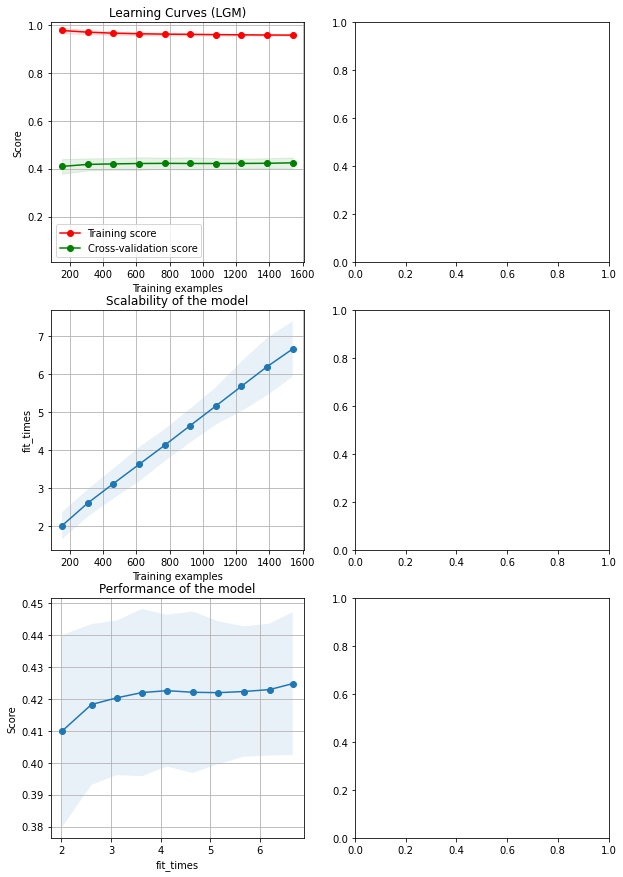

In [23]:
def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : estimator instance
        An estimator instance implementing `fit` and `predict` methods which
        will be cloned for each validation.

    title : str
        Title for the chart.

    X : array-like of shape (n_samples, n_features)
        Training vector, where ``n_samples`` is the number of samples and
        ``n_features`` is the number of features.

    y : array-like of shape (n_samples) or (n_samples, n_features)
        Target relative to ``X`` for classification or regression;
        None for unsupervised learning.

    axes : array-like of shape (3,), default=None
        Axes to use for plotting the curves.

    ylim : tuple of shape (2,), default=None
        Defines minimum and maximum y-values plotted, e.g. (ymin, ymax).

    cv : int, cross-validation generator or an iterable, default=None
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:

          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, default=None
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like of shape (n_ticks,)
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the ``dtype`` is float, it is regarded
        as a fraction of the maximum size of the training set (that is
        determined by the selected validation method), i.e. it has to be within
        (0, 1]. Otherwise it is interpreted as absolute sizes of the training
        sets. Note that for classification the number of samples usually have
        to be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt


fig, axes = plt.subplots(3, 2, figsize=(10, 15))

title = "Learning Curves (LGM)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)

plot_learning_curve(clf, title, X_train, y_train, axes=axes[:, 0], ylim=(0.01, 1.01),
                    cv=cv, n_jobs=4)

plt.show()